# Data selection for projet2-Covid

In [2]:
# Import
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from pandas_profiling import ProfileReport
import os
from sklearn.preprocessing import LabelEncoder
from category_encoders import OrdinalEncoder
import missingno as msno
%load_ext autoreload
%autoreload 2

## 1. Load data

In [2]:
# Load file with descriptions of data variables
data_description_folder = './data/'
data_description = pd.read_csv(data_description_folder + 'IDDO_SDTM_Data-Dictionary_v3.0_2022-10-06.csv', sep=';', encoding="ISO-8859-1")
data_description.columns = data_description.columns.str.replace(' ', '_')
data_description.head(3)

Domain              Domain_Name Variable_Name             Variable_Label  \
0     AU  Audiometry Test Results       STUDYID           Study Identifier   
1     AU  Audiometry Test Results        DOMAIN        Domain Abbreviation   
2     AU  Audiometry Test Results       USUBJID  Unique Subject Identifier   

  Variable_Type                                Variable_Definition  \
0     character  This variable contains the unique identifier f...   
1     character  This variable contains the two-character abbre...   
2     character  This variable contains the unique subject iden...   

  Controlled_Terminology?  
0                     NaN  
1                       Y  
2                     NaN

In [250]:
# Load data
df_list = []
data_folder = './data/DATA_2022-09-01/'
print('Names of DataFrames ---> Description :')
for f in os.listdir(data_folder):
    if f != 'IN_2022-09-01.csv':
        df_name_str = f.split('_')[0]
        df_list.append(df_name_str)
        df_name = df_name_str
        locals()[df_name] = pd.read_csv(data_folder + f, sep=',', low_memory=False) 
        locals()[df_name].name = df_name_str
        print(df_name_str, '---> ', data_description.loc[data_description.Domain==df_name_str, 'Domain_Name'].iloc[0])
    else:
        df_name_str = f.split('_')[0]
        df_list.append(df_name_str)
        df_name = df_name_str
        mylist = []
        for chunk in  pd.read_csv(data_folder + f, sep=',', low_memory=False, chunksize=7000):
            mylist.append(chunk)
        locals()[df_name] = pd.concat(mylist, axis=0)
        locals()[df_name].name = df_name_str
        del mylist

Names of DataFrames ---> Description :
DM --->  Demographics
DS --->  Disposition
ER --->  Environmental Risk
HO --->  Healthcare Encounters
IE --->  Inclusion/Exclusion Criteria
IN --->  Treatments and Interventions
LB --->  Laboratory Results
MB --->  Microbiology Specimen
PO --->  Pregnancy Outcomes
RELREC --->  Related Records
RP --->  Reproductive System Findings
RS --->  Disease Response and Clinical Classification
SA --->  Clinical and Adverse Events
SC --->  Subject Characteristics
SV --->  Subject Visits
TI --->  Trial Inclusion Exclusion Criteria
TS --->  Trial Summary
TV --->  Trial Visits
VS --->  Vital Signs


## 2. Select data

#### For DM:

In [4]:
data_folder = './data/DATA_2022-09-01/'
DM = pd.read_csv(data_folder + 'DM_2022-09-01.csv', sep=',', low_memory=False) 
DM.name = 'DM'

In [5]:
# See variables for DM
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==DM.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
130       STUDYID     character   
131        DOMAIN     character   
132       USUBJID     character   
133        SUBJID     character   
134       RFSTDTC     character   
135        DTHDTC     character   
136         DTHFL     character   
137        SITEID     character   
138         INVID     character   
139        INVNAM     character   
140           AGE        number   
141        AGETXT     character   
142          AGEU     character   
143           SEX     character   
144          RACE     character   
145        ETHNIC     character   
146         ARMCD     character   
147           ARM     character   
148       COUNTRY     character   
149         DMDTC     character   
150          DMDY        number   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Variable_Definition  
130                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
131                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    This variable contains the two-character abbreviation for the domain.  
132                                                                                                                                                                                                                                                                                                                                                              This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
133                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [6]:
# Columns really in DM
DM.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'RFSTDTC', 'DTHFL', 'INVID', 'AGE',
       'AGETXT', 'AGEU', 'SEX', 'RACE', 'ETHNIC', 'ARMCD', 'ARM', 'COUNTRY',
       'DMDY'],
      dtype='object')

In [7]:
nb_yes = DM.DTHFL.value_counts()[0]
tot = len(DM.DTHFL)
nb_nothing = tot-nb_yes

print('Yes for death: ', nb_yes, ' / ', round(nb_yes/tot*100,1), '%')
print('No info for death column: ', nb_nothing, ' / ', round(nb_nothing/tot*100,1), '%')

Yes for death:  170955  /  20.2 %
No info for death column:  673496  /  79.8 %


In [8]:
# Replace NA by N for No in DTHFL
DM.DTHFL.fillna('N', inplace=True)

In fact we will not keep this column because the information on death is provided much more precisely with DS. 

In [9]:
# Combine AGE and AGETXT

print('Values for AGETXT: ', DM['AGETXT'].unique())
print('Min and Max for AGE: ', DM['AGE'].min(), DM['AGE'].max())

DM.loc[DM.AGETXT=='95+', 'AGE'] = 96. # We make the choice to put 96 for 95+

print('Min and Max for AGE after: ', DM['AGE'].min(), DM['AGE'].max())

Values for AGETXT:  [nan '95+']
Min and Max for AGE:  -70.0 94.089996
Min and Max for AGE after:  -70.0 96.0


In [10]:
# Investigate and replace negative values for AGE

print('Values for AGEU: ', DM['AGEU'].unique())
print('Number of negative values for AGE: ', (DM['AGE']<0).sum())
print('Number of NA for AGE: ', DM['AGE'].isna().sum())

DM.loc[DM.AGE<0, 'AGE'] = np.nan # We make the choice to replace negative values by NA

print('Number of NA for AGE after: ', DM['AGE'].isna().sum())

Values for AGEU:  ['YEARS' nan 'MONTHS' 'DAYS']
Number of negative values for AGE:  8
Number of NA for AGE:  22493
Number of NA for AGE after:  22501


In [11]:
# Combine AGE and AGEU

print('Values for AGEU: ', DM['AGEU'].unique())
print('Number of NA for AGEU when AGE is not NA: ', DM.loc[DM.AGE.notna(), 'AGEU'].isna().sum())
print('Min and Max for AGE when AGEU is NA: ', DM.loc[DM.AGEU.isna(), 'AGE'].unique())
print('Min and Max for AGE: ', DM['AGE'].min(), DM['AGE'].max())

# We make the choice to keep the YEARS unit
DM.loc[DM.AGEU=='MONTHS', 'AGE'] /= 12
DM.loc[DM.AGEU=='DAYS', 'AGE'] /= 365

# TODO : Que fait-on quand NA pour AGEU ??

Values for AGEU:  ['YEARS' nan 'MONTHS' 'DAYS']
Number of NA for AGEU when AGE is not NA:  593
Min and Max for AGE when AGEU is NA:  [51. 59. 46. 74. 61. 70. 72. 50. 79. 42. 49. 38. 77. 78. 68. 58. 62. 53.
 56. nan 66. 71. 44. 52. 87. 80. 37. 41. 64. 67. 73. 27. 40. 63. 85. 88.
 91. 92. 60. 45. 76. 86. 83. 47. 57. 69. 54. 65. 55. 81. 29. 48. 43. 89.
 39. 75. 25. 36. 84. 28. 32. 33. 96. 90.  0. 24. 35. 23. 19.  3.  5. 34.
 22. 31. 20.  8. 17. 13.  4.  7. 12. 15. 16. 30. 18. 82.]
Min and Max for AGE:  0.0 96.0


In [12]:
# Investigate ARMCD and ARM
print('Values for ARMCD: ', DM['ARMCD'].unique())
print('Values for ARM: ', DM['ARM'].unique())

Values for ARMCD:  ['PER CLIN GUIDE']
Values for ARM:  ['Per Clinical Guidelines']


In [13]:
print('%NA for DMDY: ', round(DM['DMDY'].isna().sum()/DM.shape[0]*100,1))

%NA for DMDY:  64.5


At first we will keep only country and not race and ethnic because the latter two require much more cleaning.

**=> To conclude, for DM, we can keep: USUBJID, RFSTDT, AGE, SEX and COUNTRY:**

In [14]:
# Keep only some columns for DM
DM = DM[['USUBJID', 'RFSTDTC', 'AGE', 'SEX', 'COUNTRY']]
DM.columns

Index(['USUBJID', 'RFSTDTC', 'AGE', 'SEX', 'COUNTRY'], dtype='object')

In [15]:
DM.shape

(844451, 5)

#### For DS:

In [16]:
data_folder = './data/DATA_2022-09-01/'
DS = pd.read_csv(data_folder + 'DS_2022-09-01.csv', sep=',', low_memory=False) 
DS.name = 'DS'

In [17]:
# See variables for DS
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==DS.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
157       STUDYID     character   
158        DOMAIN     character   
159       USUBJID     character   
160         DSSEQ        number   
161        DSTERM     character   
162      DSMODIFY     character   
163       DSDECOD     character   
164      VISITNUM        number   
165         VISIT     character   
166       VISITDY        number   
167         EPOCH     character   
168         DSDTC     character   
169       DSSTDTC     character   
170          DSDY        number   
171        DSSTDY        number   
172         DSTPT     character   
173      DSTPTREF     character   
174        DSSTRF     character   
175      DSEVINTX     character   
176      DSSTRTPT     character   
177       DSSTTPT     character   
178      DSCDSTDY        number   
179        DSRPOC     character   

                                                                                                                                                                                                                                                                                                                                             Variable_Definition  
157                                                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
158                                                                                                                                                                                                                                                                                        This variable contains the two-character abbreviation for the domain.  
159  This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
160                                  This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
161                                                                                                                                                                                                                                                                This variable contains the verbatim wording of the event as provided by the Data Contributor.  
162                                                                                                                                                                                                            This variable contains a modification of the verbatim wording of the event. This is used to capture IDDO-defined standardised terms of the event.  
163                                                                                                                                      This variable contains a dictionary-derived text description of the event. This is defined by CDISC Controlled Terminology and IDDO Controlled Terminology. More details can be found in the IDDO Implementation Guide.  
164                                                                                                                                                                                   This variable contains a number designating the planned clinical encounter number. This is a numeric version of the visit described in VISIT?

In [18]:
# Columns really in DS
DS.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'DSSEQ', 'DSTERM', 'DSMODIFY',
       'DSDECOD', 'VISITNUM', 'VISIT', 'VISITDY', 'DSDY', 'DSSTDY', 'DSEVINTX',
       'DSCDSTDY'],
      dtype='object')

In [19]:
# Investigate DSMODIFY
print('Values for DSMODIFY: ', DS['DSMODIFY'].unique())

Values for DSMODIFY:  [nan]


In [20]:
# Investigate DSTERM and DSDECOD
print('Values for DSTERM: ', DS['DSTERM'].unique())
print('Values for DSDECOD: ', DS['DSDECOD'].unique())
# We make the choice to keep only DSDECOD

Values for DSTERM:  ['DISCHARGED ALIVE' 'DEATH' 'TRANSFER TO OTHER FACILITY'
 'MISSING IN DATABASE' 'UNKNOWN' 'HOSPITALIZATION' 'PALLIATIVE DISCHARGE'
 'Death' 'Hospitalisation' 'Discharged alive' 'Transfer to other facility'
 'Medically fit for discharge (COVID-19 resolved) but remains in hospital for other reason'
 'Palliative discharge' 'Unknown'
 'Ongoing health care needs relating to this admission for COVID-19'
 'Ongoing health care needs NOT related to COVID episode'
 'Discharged alive expected to survive' 'DISCHARGED'
 'CURRENTLY HOSPITALISED' 'DISCHARGE' 'TRANSFERRED TO ANOTHER FACILITY'
 'ALIVE' 'DECEASED' 'Forwarding to home'
 'Transfer to another health care facility' 'Hospitalization'
 'Transfer to the Health District' 'Discharge against medical advice'
 'Palliative care' 'QUARANTINE CENTER'
 'TRANSFER TO OTHER HOSPITAL/FACILITY' 'LONG TERM CARE FACILITY'
 'DEATH IN HOSPITAL' 'TRANSFERRED TO ANOTHER UNIT' 'HOSPITAL DISCHARGE'
 'DISCHARGE WITH PALLIATIVE CARE' 'HOSPITALIZED

In [21]:
# Replace UNKNOWN by NA in DSDECOD
DS['DSDECOD'].replace('UNKNOWN', np.nan, inplace=True)
print('Values for DSDECOD: ', DS['DSDECOD'].unique())

Values for DSDECOD:  ['DISCHARGED' 'DEATH' 'TRANSFERRED' nan 'STILL IN HOSPITAL'
 'LOST TO FOLLOW-UP']


In [22]:
DS.DSDECOD.value_counts()

DISCHARGED           608454
DEATH                170551
TRANSFERRED           28089
STILL IN HOSPITAL     12868
LOST TO FOLLOW-UP         3
Name: DSDECOD, dtype: int64

In [23]:
DS.DSDECOD.value_counts(normalize=True)

DISCHARGED           0.742049
DEATH                0.207998
TRANSFERRED          0.034256
STILL IN HOSPITAL    0.015693
LOST TO FOLLOW-UP    0.000004
Name: DSDECOD, dtype: float64

In [24]:
round(DS.DSDECOD.isna().sum()/len(DS.DSDECOD),3)

0.006

In [25]:
# Investigate VISITNUM, VISIT and VISITDY

print('Values for VISITNUM: ', DS['VISITNUM'].unique())
print('Values for VISIT: ', DS['VISIT'].unique())
print('Values for VISITDY: ', DS['VISITDY'].unique())

print('%NA for VISITNUM: ', round(DS['VISITNUM'].isna().sum()/DS.shape[0]*100,2))
print('%NA for VISIT: ', round(DS['VISIT'].isna().sum()/DS.shape[0]*100,2))
print('%NA for VISITDY: ', round(DS['VISITDY'].isna().sum()/DS.shape[0]*100,2))

Values for VISITNUM:  [nan  1.  2.]
Values for VISIT:  [nan 'Day 0' 'Week 2 Day 14']
Values for VISITDY:  [nan  1. 15.]
%NA for VISITNUM:  99.82
%NA for VISIT:  99.82
%NA for VISITDY:  99.82


In [26]:
# Investigate DSDY, DSEVINTX and DSCDSTDY

print('Values for DSDY: ', DS['DSDY'].unique())
print('Values for DSEVINTX: ', DS['DSEVINTX'].unique())
print('Values for DSCDSTDY: ', DS['DSCDSTDY'].unique())

print('%NA for DSDY: ', round(DS['DSDY'].isna().sum()/DS.shape[0]*100,2))
print('%NA for DSEVINTX: ', round(DS['DSEVINTX'].isna().sum()/DS.shape[0]*100,2))
print('%NA for DSCDSTDY: ', round(DS['DSCDSTDY'].isna().sum()/DS.shape[0]*100,2))

Values for DSDY:  [nan 78. 75. 29. 28. 24. 17. 32. 25. 21. 22. 30. 50. 38. 33. 36. 31. 45.
 80. 35. 59. 63. 34. 27. 26. 39. 49. 53. 16. 19. 20. 37. 72. 46. 11. 40.
 23. 48. 42. 54. 14. 90. 41. 51. 13.  7. 12.]
Values for DSEVINTX:  [nan 'AT ANY TIME AFTER DISCHARGE']
Values for DSCDSTDY:  [ nan  16.   2.  20.   8.   5.   4.   1.   9.  14.  25.  51.  18.  19.
  24.  12.  55.   6.  13.  23.  28. 109.   7.  11.  21.   3.]
%NA for DSDY:  99.88
%NA for DSEVINTX:  99.84
%NA for DSCDSTDY:  99.99


**=> To conclude, for DS, we can keep: USUBJID, DSSEQ and DSDECOD:**

In [27]:
# Keep only some columns for DS
DS = DS[['USUBJID', 'DSSEQ', 'DSDECOD']]
DS.columns

Index(['USUBJID', 'DSSEQ', 'DSDECOD'], dtype='object')

In [28]:
DS.shape

(824787, 3)

#### For ER:

In [29]:
data_folder = './data/DATA_2022-09-01/'
ER = pd.read_csv(data_folder + 'ER_2022-09-01.csv', sep=',', low_memory=False) 
ER.name = 'ER'

In [30]:
# See variables for ER
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==ER.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
180       STUDYID     character   
181        DOMAIN     character   
182       USUBJID     character   
183         ERSEQ        number   
184        ERTERM     character   
185      ERMODIFY     character   
186         ERCAT     character   
187        ERSCAT     character   
188       ERPRESP     character   
189       EROCCUR     character   
190        ERSTAT     character   
191      ERREASND     character   
192      VISITNUM        number   
193         VISIT     character   
194       VISITDY        number   
195         EPOCH     character   
196         ERDTC     character   
197       ERSTDTC     character   
198       ERENDTC     character   
199          ERDY        number   
200        ERSTDY        number   
201        ERENDY        number   
202         ERTPT     character   
203      ERTPTREF     character   
204        ERSTRF     character   
205      EREVLINT     character   
206      EREVINTX     character   
207       ERCNTRY     character   

                                                                                                                                                                                                                                                                                                                                             Variable_Definition  
180                                                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
181                                                                                                                                                                                                                                                                                        This variable contains the two-character abbreviation for the domain.  
182  This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
183                                  This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
184                                                                                                                                                                                                                                                                This variable contains the verbatim wording of the event as provided by the Data Contributor.  
185                                                                                                                                                                                                            This variable contains a modification of the verbatim wording of the event. This is used to capture IDDO-defined standardised terms of the event.  
186                                                                                                                                                                                                                                                                                                  This variable contains a categorization of the observation.  
187                                                                                                                                                 

In [31]:
# Columns really in ER
ER.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'ERSEQ', 'ERTERM', 'ERCAT', 'ERPRESP',
       'EROCCUR', 'ERSTAT', 'ERREASND', 'VISITNUM', 'VISIT', 'VISITDY', 'ERDY',
       'ERSTDY', 'ERENDY', 'EREVINTX', 'ERCNTRY'],
      dtype='object')

In [32]:
# Investigate ERCAT
print('Values for ERCAT: ', ER['ERCAT'].unique())

Values for ERCAT:  ['COVID-19 RISK FACTOR']


**=> To conclude, for ER, we can keep nothing because there is no decod of the event, and ECAT is only one value.**

#### For HO:

In [33]:
data_folder = './data/DATA_2022-09-01/'
HO = pd.read_csv(data_folder + 'HO_2022-09-01.csv', sep=',', low_memory=False) 
HO.name = 'HO'

In [34]:
# See variables for HO
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==HO.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
208       STUDYID     character   
209        DOMAIN     character   
210       USUBJID     character   
211         HOSEQ        number   
212       HOREFID     character   
213        HOTERM     character   
214       HODECOD     character   
215         HOCAT     character   
216       HOPRESP     character   
217       HOOCCUR     character   
218        HOSTAT     character   
219      HOREASND     character   
220        HOPATT        number   
221      VISITNUM        number   
222         VISIT     character   
223       VISITDY        number   
224         HODTC     character   
225       HOSTDTC     character   
226       HOENDTC     character   
227          HODY        number   
228        HOSTDY        number   
229        HOENDY        number   
230         HODUR     character   
231         HOTPT     character   
232      HOTPTREF     character   
233        HOSTRF     character   
234      HOEVINTX     character   
235      HOCDSTDY        number   
236      HODISOUT     character   
237      SELFCARE     character   
238        HOINDC     character   

                                                                                                                                                                                                                                                                                                                                             Variable_Definition  
208                                                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
209                                                                                                                                                                                                                                                                                        This variable contains the two-character abbreviation for the domain.  
210  This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
211                                  This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
212                                                                                                           This variable contains an identifier to distinguish duplicate findings, collections or events occurring within the same time period where no other timing information is available. This variable is used to make the rows' timing details unique.  
213                                                                                                                                                                                                                                                                This variable contains the verbatim wording of the event as provided by the Data Contributor.  
214                                                                                                                                      This variable contains a dictionary-derived text description of the event. This is defined by CDISC Controlled Terminology and IDDO Controlled Terminology. More details can be found in the IDDO Implementation Guide.  
215                                        

In [35]:
# Columns really in HO
HO.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'HOSEQ', 'HOREFID', 'HOTERM', 'HODECOD',
       'HOCAT', 'HOPRESP', 'HOOCCUR', 'HOSTAT', 'HOREASND', 'HOPATT',
       'VISITNUM', 'VISIT', 'VISITDY', 'HODY', 'HOSTDY', 'HOENDY', 'HODUR',
       'HOSTRF', 'HOEVINTX', 'HOCDSTDY', 'HODISOUT', 'SELFCARE', 'HOINDC'],
      dtype='object')

In [36]:
# Investigate HODECOD
print('Values for HODECOD: ', HO['HODECOD'].unique())

Values for HODECOD:  ['HOSPITAL' 'INTENSIVE CARE UNIT']


In [37]:
# NA value for HODY
print('%NA for HODY: ', round(HO['HODY'].isna().sum()/HO.shape[0]*100,2))

%NA for HODY:  65.12


**=> To conclude, for HO, we can keep: USUBJID, HOSEQ and HODECOD:**

In [38]:
# Keep only some columns for HO
HO = HO[['USUBJID', 'HOSEQ', 'HODECOD']]
HO.columns

Index(['USUBJID', 'HOSEQ', 'HODECOD'], dtype='object')

In [39]:
HO.shape

(2336786, 3)

#### For IE:

In [40]:
data_folder = './data/DATA_2022-09-01/'
IE = pd.read_csv(data_folder + 'IE_2022-09-01.csv', sep=',', low_memory=False) 
IE.name = 'IE'

In [41]:
# See variables for IE
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==IE.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
239       STUDYID     character   
240        DOMAIN     character   
241       USUBJID     character   
242         IESEQ        number   
243      IETESTCD     character   
244        IETEST     character   
245         IECAT     character   
246       IEORRES     character   
247      IESTRESC     character   
248        IESTAT     character   
249      IEREASND     character   
250         IEDTC     character   
251          IEDY        number   

                                                                                                                                                                                                                                                                                                                                                                                Variable_Definition  
239                                                                                                                                                                                                    This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
240                                                                                                                                                                                                                                                                                                                           This variable contains the two-character abbreviation for the domain.  
241                                     This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
242                                                                     This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
243                                                                                                                                                                                                                                                                                                 This variable identifies the shortened code for the name of the test or examination performed.   
244                                                                                                                                                                                                                                                                                                                         This variable identifies the name of the test or examination performed.  
245                                                                                                                                                                                                                                                                                                                                     This variable contains a categorization of the observation.  
246                                                                                                                                                                                                    This variable contains the result of the test or examination performed as provided by the data contributor. The original data can be either numericm e.g. "503" or string, e.g., "Positive".  
247

In [42]:
# Columns really in IE
IE.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'IESEQ', 'IETESTCD', 'IETEST', 'IECAT',
       'IEORRES', 'IESTRESC', 'IESTAT', 'IEREASND', 'IEDY'],
      dtype='object')

**=> To conclude, for IE, we can keep nothing.**

#### For IN:

In [43]:
data_folder = './data/DATA_2022-09-01/'
mylist = []
for chunk in pd.read_csv(data_folder + 'IN_2022-09-01.csv', sep=',', low_memory=False, chunksize=5000):
    mylist.append(chunk)
IN = pd.concat(mylist, axis=0)
IN.name = 'IN'
del mylist

In [44]:
# See variables for IN
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==IN.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
252       STUDYID     character   
253        DOMAIN     character   
254       USUBJID     character   
255       SPDEVID     character   
256         INSEQ        number   
..            ...           ...   
312      DOSVOMIT     character   
313        DOTIND     character   
314         RDIND     character   
315       TDOSIND     character   
316      FATGIVEN     character   

                                                                                                                                                                                                                                                                                                                                             Variable_Definition  
252                                                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
253                                                                                                                                                                                                                                                                                        This variable contains the two-character abbreviation for the domain.  
254  This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
255                                                                                  This variable contains the short code for the device in use. This code will be the same as in the DI domain under the same variable name (SPDEVID). This functions as a key to link the descriptions of the device found in the DI domain with the usage in the IN domain.   
256                                  This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
..                                                                                                                                                                                                                                                                                                                                                           ...  
312                                                                                                                                                                                                                                                                                          This variable identifies whether or not the dose given was vomited.  
313                                                                                                                                                                                                                           This variable identifies whether ot not the treatment or intervention was administered under direct observation of research staff.  
314                                                                                                                                                                                                                                                             This variable identifies if the dose given was a redose due to the previous dose being vomited.   
315                              

In [45]:
# Columns really in IN
IN.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'SPDEVID', 'INSEQ', 'INREFID', 'INTRT',
       'INMODIFY', 'INDECOD', 'INCAT', 'INSCAT', 'INPRESP', 'INOCCUR',
       'INSTAT', 'INREASND', 'ININDC', 'INCLAS', 'INCLASCD', 'INDOSE',
       'INDOSTXT', 'INDOSU', 'INDOSFRM', 'INDOSFRQ', 'INDOSTOT', 'INDOSRGM',
       'INROUTE', 'VISITNUM', 'VISIT', 'VISITDY', 'INDY', 'INSTDY', 'INENDY',
       'INDUR', 'INSTRF', 'INEVLINT', 'INEVINTX', 'INCDSTDY'],
      dtype='object')

In [46]:
# Investigate INCLAS
print('Values for INCLAS: ', IN['INCLAS'].unique())

Values for INCLAS:  ['ARTIFICIAL RESPIRATION' 'ANTIMALARIALS' 'OXYGEN'
 'ANTIVIRALS FOR SYSTEMIC USE' 'HIGH FLOW OXYGEN NASAL CANNULA'
 'CORTICOSTEROIDS FOR SYSTEMIC USE' 'CHEMOTHERAPY'
 'ANTIINFLAMMATORY AND ANTIRHEUMATIC PRODUCTS, NON-STEROIDS'
 'EXTRACORPOREAL MEMBRANE OXYGENATION' 'IMMUNOSTIMULANTS'
 'PRONE BODY POSITION' 'CARDIOPULMONARY RESUSCITATION'
 'IMMUNOSUPPRESSANTS' 'RENAL REPLACEMENT'
 'ANTIBACTERIALS FOR SYSTEMIC USE' nan 'ANTITHROMBOTIC AGENTS'
 'ANTIMYCOTICS FOR SYSTEMIC USE' 'CARDIAC THERAPY' 'VACCINES'
 'CARDIAC PACING' 'AGENTS ACTING ON THE RENIN-ANGIOTENSIN SYSTEM'
 'NONINVASIVE VENTILATION' 'IMMUNOGLOBULINS' 'ANALGESICS'
 'TRANSFUSION OF BLOOD PRODUCT' 'LIPID MODIFYING AGENTS'
 'DRUGS FOR ACID RELATED DISORDERS' 'MUSCLE RELAXANTS'
 'OTHER RESPIRATORY SYSTEM PRODUCTS' 'INSERTION OF TRACHEOSTOMY TUBE'
 'DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES' 'PSYCHOLEPTICS' 'DIURETICS'
 'BETA BLOCKING AGENTS' 'ANESTHETICS'
 'BLOOD SUBSTITUTES AND PERFUSION SOLUTIONS' 'BRONCHOSCOPY'


In [47]:
# Investigate INCLAS
print('Values for INCLAS:\n', IN['INCLAS'].value_counts(normalize=True, dropna=False))

Values for INCLAS:
 ANTIVIRALS FOR SYSTEMIC USE                                  0.099480
ARTIFICIAL RESPIRATION                                       0.091678
CORTICOSTEROIDS FOR SYSTEMIC USE                             0.083986
IMMUNOSUPPRESSANTS                                           0.068704
OXYGEN                                                       0.062425
ANTIBACTERIALS FOR SYSTEMIC USE                              0.059972
NaN                                                          0.048714
HIGH FLOW OXYGEN NASAL CANNULA                               0.044329
ANTIINFLAMMATORY AND ANTIRHEUMATIC PRODUCTS, NON-STEROIDS    0.040269
CARDIAC THERAPY                                              0.038568
PRONE BODY POSITION                                          0.035545
NONINVASIVE VENTILATION                                      0.035530
EXTRACORPOREAL MEMBRANE OXYGENATION                          0.035166
ANTIMYCOTICS FOR SYSTEMIC USE                                0.030266


In [48]:
# Count NA for INDY
print('%NA for INDY: ', round(IN['INDY'].isna().sum()/IN.shape[0]*100,1))

%NA for INDY:  66.2


**=> To conclude, for IN, we can keep: USUBJID, INSEQ and INCLAS:**

In [49]:
# Keep only some columns for IN
IN.drop(columns =['STUDYID', 'DOMAIN', 'SPDEVID', 'INREFID', 'INTRT',
       'INMODIFY', 'INDECOD', 'INCAT', 'INSCAT', 'INPRESP', 'INOCCUR',
       'INSTAT', 'INREASND', 'ININDC', 'INCLASCD', 'INDOSE',
       'INDOSTXT', 'INDOSU', 'INDOSFRM', 'INDOSFRQ', 'INDOSTOT', 'INDOSRGM',
       'INROUTE', 'VISITNUM', 'VISIT', 'VISITDY', 'INDY', 'INSTDY', 'INENDY',
       'INDUR', 'INSTRF', 'INEVLINT', 'INEVINTX', 'INCDSTDY'], inplace=True)
IN.columns

Index(['USUBJID', 'INSEQ', 'INCLAS'], dtype='object')

In [50]:
IN.shape

(43338429, 3)

#### For LB:

In [51]:
data_folder = './data/DATA_2022-09-01/'
LB = pd.read_csv(data_folder + 'LB_2022-09-01.csv', sep=',', low_memory=False) 
LB.name = 'LB'

In [52]:
# See variables for LB
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==LB.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
317       STUDYID     character   
318        DOMAIN     character   
319       USUBJID     character   
320         LBSEQ        number   
321       LBREFID     character   
322      LBTESTCD     character   
323        LBTEST     character   
324         LBCAT     character   
325        LBSCAT     character   
326       LBORRES     character   
327      LBORRESU     character   
328      LBORNRLO        number   
329      LBORNRHI        number   
330      LBSTRESC     character   
331      LBSTRESN        number   
332      LBSTRESU     character   
333        LBSTAT     character   
334      LBREASND     character   
335         LBNAM     character   
336        LBSPEC     character   
337      LBSPCCND     character   
338      LBMETHOD     character   
339      VISITNUM        number   
340         VISIT     character   
341       VISITDY        number   
342         EPOCH     character   
343         LBDTC     character   
344       LBENDTC     character   
345          LBDY        number   
346        LBENDY        number   
347         LBTPT     character   
348      LBTPTNUM        number   
349      LBTPTREF     character   
350        LBSTRF     character   
351      LBEVINTX     character   
352      LBSTRTPT     character   
353       LBSTTPT     character   
354      LBCDSTDY        number   
355        LBRPOC     character   

                                                                                                                                                                                                                                                                                                                                                                                Variable_Definition  
317                                                                                                                                                                                                    This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
318                                                                                                                                                                                                                                                                                                                           This variable contains the two-character abbreviation for the domain.  
319                                     This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
320                                                                     This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
321                                                                                                                                              This variable contains an identifier to distinguish duplicate findings, collections or events occurring within the same time period where no other timing information is available. This variable is used to make the rows' timing details unique.  
322                                                                                                                                                                                                                                                 This variable ident

In [53]:
# Columns really in LB
LB.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'LBSEQ', 'LBTESTCD', 'LBTEST', 'LBCAT',
       'LBSCAT', 'LBORRES', 'LBORRESU', 'LBSTRESC', 'LBSTRESN', 'LBSTRESU',
       'LBSTAT', 'LBREASND', 'LBSPEC', 'LBMETHOD', 'VISITNUM', 'VISIT',
       'VISITDY', 'LBDY', 'LBSTRF', 'LBEVINTX', 'LBCDSTDY'],
      dtype='object')

In [54]:
# Investigate LBTESTCD
print('Values for LBTESTCD: ', LB['LBTESTCD'].unique())

Values for LBTESTCD:  ['HCT' 'PLAT' 'HGB' 'WBC' 'AST' 'BILI' 'CREAT' 'LYM' 'INR' 'PCO2' 'NEUT'
 'PT' 'UREAN' 'CRP' 'ALT' 'GLUC' 'PH' 'SODIUM' 'BICARB' 'PO2' 'K' 'CK'
 'TROPONI' 'LDH' 'FERRITIN' 'PCT' 'DDIMER' 'LACTICAC' 'NEUTLE' 'LYMLE'
 'BASEEXCS' 'INTLK6' 'APTT' 'APTTSTND' 'HBA1C' 'ESR' 'OXYSAT' 'ALB'
 'TROPONIN' 'MCH' 'RBC' 'RDW' 'IRON' 'MONO' 'EOS' 'EOSLE' 'BASOLE'
 'MONOLE' 'MCHC' 'MCV' 'PROT' 'CL' 'AMYLASE' 'MPV' 'PLATHCT' 'BASO' 'CHOL'
 'URATE' 'PTAC' 'FIBRINO' 'BILDIR' 'CA' 'GGT' 'TT' 'MG' 'CAION' 'CAIONPH'
 'CARBXHGB' 'HGBDOXY' 'HGBMET' 'HGBOXY' 'CO2' 'TROPONT' 'PO2FIO2'
 'FIBRINOF' 'UREA' 'ALP' 'CD4' 'NEUTSG' 'AUERRODS']


In [55]:
# Check units
for t in LB['LBTESTCD'].unique():
    print(t, ' ---> ', LB.LBSTRESU[LB.LBTESTCD == t].unique())

HCT  --->  ['%' nan]
PLAT  --->  ['10^9/L' nan]
HGB  --->  ['g/L' nan]
WBC  --->  ['10^9/L' nan]
AST  --->  ['U/L' nan]
BILI  --->  ['umol/L' nan]
CREAT  --->  ['umol/L' nan]
LYM  --->  ['10^9/L' nan]
INR  --->  ['RATIO' nan]
PCO2  --->  [nan]
NEUT  --->  ['10^9/L' nan]
PT  --->  ['sec' nan]
UREAN  --->  ['mmol/L' nan]
CRP  --->  ['mg/L' nan]
ALT  --->  ['U/L' nan]
GLUC  --->  ['mmol/L' nan]
PH  --->  [nan]
SODIUM  --->  ['mmol/L' nan]
BICARB  --->  ['mEq/L' nan]
PO2  --->  [nan]
K  --->  ['mmol/L' nan]
CK  --->  ['U/L' nan]
TROPONI  --->  ['ug/L' nan]
LDH  --->  ['U/L' nan]
FERRITIN  --->  ['ug/L' nan]
PCT  --->  ['ug/L' nan]
DDIMER  --->  [nan 'mg/L']
LACTICAC  --->  ['mmol/L' nan]
NEUTLE  --->  ['%']
LYMLE  --->  ['%']
BASEEXCS  --->  ['mmol/L' nan]
INTLK6  --->  ['ng/L' nan]
APTT  --->  ['sec' nan]
APTTSTND  --->  ['RATIO' nan]
HBA1C  --->  [nan]
ESR  --->  [nan 'mm/h']
OXYSAT  --->  [nan]
ALB  --->  [nan]
TROPONIN  --->  [nan]
MCH  --->  [nan]
RBC  --->  [nan]
RDW  --->  [nan]
IRO

There is only one unit for each test so we do not need to uniformize them.

In [56]:
# NA for LBDY
print('%NA for LB: ', round(LB['LBDY'].isna().sum()/LB.shape[0]*100,2))

%NA for LB:  2.01


**=> To conclude, for LB, we can keep: USUBJID, LBSEQ, LBTESTCD, LBSTRESC, LBSTRESU and LBDY:**

In [57]:
# Keep only some columns for LB
LB = LB[['USUBJID', 'LBSEQ', 'LBTESTCD', 'LBSTRESC', 'LBSTRESU', 'LBDY']]
LB.columns

Index(['USUBJID', 'LBSEQ', 'LBTESTCD', 'LBSTRESC', 'LBSTRESU', 'LBDY'], dtype='object')

In [58]:
LB.shape

(7330863, 6)

#### For MB:

In [59]:
data_folder = './data/DATA_2022-09-01/'
MB = pd.read_csv(data_folder + 'MB_2022-09-01.csv', sep=',', low_memory=False) 
MB.name = 'MB'

In [60]:
# See variables for MB
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==MB.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
356       STUDYID     character   
357        DOMAIN     character   
358       USUBJID     character   
359         MBSEQ        number   
360       MBGRPID     character   
361       MBREFID     character   
362      MBTESTCD     character   
363        MBTEST     character   
364      MBMODIFY     character   
365      MBTSTDTL     character   
366         MBCAT     character   
367        MBSCAT     character   
368       MBORRES     character   
369      MBORRESU     character   
370      MBSTRESC     character   
371      MBSTRESN        number   
372      MBSTRESU     character   
373        MBSTAT     character   
374      MBREASND     character   
375        MBSPEC     character   
376      MBSPCCND     character   
377         MBLOC     character   
378      MBMETHOD     character   
379      VISITNUM        number   
380         VISIT     character   
381       VISITDY        number   
382         EPOCH     character   
383         MBDTC     character   
384          MBDY        number   
385         MBTPT     character   
386      MBTPTNUM        number   
387      MBTPTREF     character   
388        MBELTM     character   
389        MBSTRF     character   
390      MBEVINTX     character   
391      MBSTRTPT     character   
392       MBSTTPT     character   
393      MBCDSTDY        number   
394        MBRPOC     character   

                                                                                                                                                                                                                                                                                                                                                                                Variable_Definition  
356                                                                                                                                                                                                    This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
357                                                                                                                                                                                                                                                                                                                           This variable contains the two-character abbreviation for the domain.  
358                                     This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
359                                                                     This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
360                                                                                                        This variable contains an identifier used to link together a block of related records and distinguish duplicate findings or events that occur within the same time period where no other timing information is available. This variable is used to make the rows' timing details unique.  
361                                                                                                                                              This variable contains an identifier to distinguish duplicate findings, collections or events occurring within the sam

In [61]:
# Columns really in MB
MB.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'MBSEQ', 'MBTESTCD', 'MBTEST',
       'MBTSTDTL', 'MBCAT', 'MBSCAT', 'MBORRES', 'MBORRESU', 'MBSTRESC',
       'MBSTRESN', 'MBSTRESU', 'MBSTAT', 'MBREASND', 'MBSPEC', 'MBLOC',
       'MBMETHOD', 'VISITNUM', 'VISIT', 'VISITDY', 'MBDY', 'MBSTRF',
       'MBEVINTX', 'MBCDSTDY'],
      dtype='object')

In [62]:
# Investigate MBTESTCD
print('Values for MBTESTCD: ', MB['MBTESTCD'].unique())

Values for MBTESTCD:  ['BACT' 'RSV' 'CRONAVIR' 'ADENOVIR' 'OTHRDIND' 'INFLUVIR' 'SARSCOV2'
 'MCORGIDN' 'HIV12P24' 'PLSMDM' 'HIV' 'OTHPHIND' 'PFALCIP' 'SAR2IGG'
 'SAR2IGM' 'SAR2IGGM' 'SAR2AB']


In [63]:
# Investigate MBTSTDTL
print('Values for MBTSTDTL: ', MB['MBTSTDTL'].unique())

Values for MBTSTDTL:  ['DETECTION' 'IDENTIFICATION' 'VARIANT TYPE']


In [64]:
# Replace UNKNOWN by NA in MBSTRESC
MB.replace('UNKNOWN', np.nan, inplace=True)

In [65]:
# Replace NOT SURE by NA in MBSTRESC
MB.replace('NOT SURE', np.nan, inplace=True)

In [66]:
# Investigate MBSTRESC
print('Values for MBSTRESC for detection:\n', MB.loc[MB.MBTSTDTL=='DETECTION', 'MBSTRESC'].value_counts(normalize=True, dropna=False))

Values for MBSTRESC for detection:
 POSITIVE    0.477894
NaN         0.277023
NEGATIVE    0.245084
Name: MBSTRESC, dtype: float64


In [67]:
# Investigate MBSTRESC
print('Values for MBSTRESC for identification:\n', MB.loc[MB.MBTSTDTL=='IDENTIFICATION', 'MBSTRESC'].value_counts(normalize=True, dropna=False))

Values for MBSTRESC for identification:
 SEVERE ACUTE RESPIRATORY SYNDROME CORONAVIRUS 2    0.819583
NaN                                                0.068448
ESCHERICHIA COLI                                   0.009928
METHICILLIN RESISTANT STAPHYLOCOCCUS AUREUS        0.009609
STAPHYLOCOCCUS AUREUS                              0.006104
                                                     ...   
ROTHIA DENTOCARIOSA                                0.000008
CAMPYLOBACTER COLI                                 0.000008
MEASLES MORBILLIVIRUS                              0.000008
PSYCHROBACTER PHENYLPYRUVICUS                      0.000008
PLASMODIUM                                         0.000008
Name: MBSTRESC, Length: 338, dtype: float64


In [68]:
# Investigate MBSTRESC
print('Values for MBSTRESC for variant type:\n', MB.loc[MB.MBTSTDTL=='VARIANT TYPE', 'MBSTRESC'].value_counts(normalize=True, dropna=False))

Values for MBSTRESC for variant type:
 NaN                    0.565113
OMICRON - B.1.1.529    0.282316
DELTA - B.1.617.2      0.096348
BETA - B.1.351         0.040005
OMICRON                0.011413
ALPHA - B.1.1.7        0.004565
THETA- P.3             0.000120
KAPPA - B.1.617.1      0.000120
Name: MBSTRESC, dtype: float64


In [69]:
# Investigate MBTESTCD
print('Values for MBTESTCD for not detection: ', MB.loc[MB.MBTSTDTL!='DETECTION', 'MBTESTCD'].unique())

Values for MBTESTCD for not detection:  ['MCORGIDN' 'SARSCOV2']


In [70]:
# Investigate MBTESTCD
print('Values for MBTESTCD:\n', MB['MBTESTCD'].value_counts(normalize=True, dropna=False))

Values for MBTESTCD:
 SARSCOV2    4.473739e-01
INFLUVIR    2.859827e-01
MCORGIDN    6.206561e-02
CRONAVIR    5.116250e-02
RSV         5.113892e-02
ADENOVIR    4.509914e-02
BACT        4.349690e-02
OTHRDIND    9.830854e-03
HIV         1.187303e-03
PLSMDM      1.106672e-03
OTHPHIND    9.737020e-04
HIV12P24    2.866881e-04
PFALCIP     2.739568e-04
SAR2IGGM    1.178816e-05
SAR2IGG     6.601370e-06
SAR2IGM     2.357632e-06
SAR2AB      4.715264e-07
Name: MBTESTCD, dtype: float64


In [71]:
# NA value for MBDY
print('%NA for MBDY: ', round(MB['MBDY'].isna().sum()/MB.shape[0]*100,2))

%NA for MBDY:  99.16


**=> To conclude, for MB, we can keep: USUBJID, MBSEQ, MBTESTCD, MBTSTDTL and MBSTRESC**

In [72]:
# Keep only some columns for MB
MB = MB[['USUBJID', 'MBSEQ', 'MBTESTCD', 'MBTSTDTL', 'MBSTRESC']]
MB.columns

Index(['USUBJID', 'MBSEQ', 'MBTESTCD', 'MBTSTDTL', 'MBSTRESC'], dtype='object')

In [73]:
MB.shape

(2120772, 5)

#### For PO:

In [74]:
data_folder = './data/DATA_2022-09-01/'
PO = pd.read_csv(data_folder + 'PO_2022-09-01.csv', sep=',', low_memory=False) 
PO.name = 'PO'

In [75]:
# See variables for PO
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==PO.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
519       STUDYID     character   
520        DOMAIN     character   
521       USUBJID     character   
522         POSEQ        number   
523        POTERM     character   
524      POMODIFY     character   
525         POCAT     character   
526       POPRESP     character   
527       POOCCUR     character   
528        POSTAT     character   
529      POREASND     character   
530      VISITNUM        number   
531         VISIT     character   
532       VISITDY        number   
533         EPOCH     character   
534         PODTC     character   
535       POSTDTC     character   
536       POENDTC     character   
537          PODY        number   
538        POSTDY        number   
539        POENDY        number   
540        POSTRF     character   
541        POENRF     character   
542      POFETNUM        number   
543      POFTINID        number   
544      POMODDLV     character   
545      POSETTNG     character   

                                                                                                                                                                                                                                                                                                                                             Variable_Definition  
519                                                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
520                                                                                                                                                                                                                                                                                        This variable contains the two-character abbreviation for the domain.  
521  This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
522                                  This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
523                                                                                                                                                                                                                                                                This variable contains the verbatim wording of the event as provided by the Data Contributor.  
524                                                                                                                                                                                                            This variable contains a modification of the verbatim wording of the event. This is used to capture IDDO-defined standardised terms of the event.  
525                                                                                                                                                                                                                                                                                                  This variable contains a categorization of the observation.  
526                                                                                                                                                                           This vari

In [76]:
# Columns really in PO
PO.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'POSEQ', 'POTERM', 'POCAT', 'VISITNUM',
       'VISIT', 'VISITDY', 'PODY', 'POSTDY', 'POENDY'],
      dtype='object')

In [77]:
# Investigate POTERM
print('Values for var: ', PO['POTERM'].unique())

Values for var:  ['Live Birth' 'Pregnancy' 'UNKNOWN' 'Stillbirth' 'Born Alive']


The only important thing is that the person is pregnant, as the outcome of the delivery is always the same. However, this information is already in the RP table so nothing will be kept from PO.

**=> To conclude, for PO, we can keep nothing.**

#### For RELREC:

In [78]:
data_folder = './data/DATA_2022-09-01/'
RELREC = pd.read_csv(data_folder + 'RELREC_2022-09-01.csv', sep=',', low_memory=False) 
RELREC.name = 'RELREC'

In [79]:
# See variables for RELREC
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==RELREC.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
600       STUDYID     character   
601       USUBJID     character   
602       RSUBJID     character   
603        RELREC     character   

                                                                                                                                                                                                                                                                                                                                             Variable_Definition  
600                                                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
601  This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
602                                                                                                                                                                                                                                                                 This variable contains the related unique subject identifier from the same or another study.  
603                                                                                                                                                                    This variable contains the patient relationship type between the identifier contained in USUBJID and the identifier contained in RSUBJID. This is defined by IDDO Controlled Terminology.

In [80]:
# Columns really in RELREC
RELREC.columns

Index(['STUDYID', 'USUBJID', 'RSUBJID', 'RELREC'], dtype='object')

In [81]:
# Investigate var
print('Values for var: ', RELREC['RELREC'].unique())

Values for var:  ['SAME']


**=> To conclude, for RELREC, we can keep nothing.**

#### For RP:

In [82]:
data_folder = './data/DATA_2022-09-01/'
RP = pd.read_csv(data_folder + 'RP_2022-09-01.csv', sep=',', low_memory=False) 
RP.name = 'RP'

In [83]:
# See variables for RP
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==RP.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
604       STUDYID     character   
605        DOMAIN     character   
606       USUBJID     character   
607         RPSEQ        number   
608      RPTESTCD     character   
609        RPTEST     character   
610         RPCAT     character   
611        RPSCAT     character   
612       RPORRES     character   
613      RPORRESU     character   
614      RPSTRESC     character   
615      RPSTRESN        number   
616      RPSTRESU     character   
617        RPSTAT     character   
618      RPREASND     character   
619      RPMETHOD     character   
620      VISITNUM        number   
621         VISIT     character   
622       VISITDY        number   
623         EPOCH     character   
624         RPDTC     character   
625          RPDY        number   
626         RPDUR     character   
627         RPTPT     character   
628      RPTPTREF     character   
629        RPSTRF     character   
630      RPEVINTX     character   
631      RPSTRTPT     character   
632       RPSTTPT     character   
633      RPCDSTDY        number   

                                                                                                                                                                                                                                                                                                                                                                                Variable_Definition  
604                                                                                                                                                                                                    This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
605                                                                                                                                                                                                                                                                                                                           This variable contains the two-character abbreviation for the domain.  
606                                     This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
607                                                                     This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
608                                                                                                                                                                                                                                                 This variable identifies the shortened code for the name of the test or examination performed. This is defined by CDISC Controlled Terminology.  
609                                                                                                                                                                                                                                                                        This variable identifies the name of the test or examination performed. This is defined by CDISC Controlled Terminology.  
610                                                                                                                                                                                         

In [84]:
# Columns really in RP
RP.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'RPSEQ', 'RPTESTCD', 'RPTEST',
       'RPORRES', 'RPORRESU', 'RPSTRESC', 'RPSTRESN', 'RPSTRESU', 'RPSTAT',
       'RPREASND', 'VISITNUM', 'VISIT', 'VISITDY', 'RPDY'],
      dtype='object')

In [85]:
# Investigate RPTESTCD
print('Values for RPTESTCD: ', RP['RPTESTCD'].unique())

Values for RPTESTCD:  ['PREGIND' 'EGESTAGE']


In [86]:
# Investigate RPSTRESC
print('Values for RPSTRESC: ', RP['RPSTRESC'].unique())

Values for RPSTRESC:  [nan 'N' '27' 'Y' 'U' '40' '36' '25' '30' '39' '37' '22' '31' '20' '24'
 '26' '3' '28' '32' '12' '38' '33' '23' '9' '8' '13' '29' '18' '41' '35'
 '34.00' '37.00' '38.00' '33.00' '40.00' '7.00' '41.00' '28.00' '32.00'
 '00.06' '25.00' '38.01' '40.02' '40.04' '40.01' '37.02' '34.06' '39.00'
 '8.00' '41.60' '35.00' '39.04' '30.00' '36.00' '27.00' '20.05' '35.50'
 '40.20' '27.03' '12.00' '37.10' '36.10' '39.20' '39.50' '38.50' '38.80'
 '38.60' '6.00' '20.00' '9.00' '29.00' '22.00' '38.10' '33.60' '18.00'
 '35.40' '22.20' '31.00' '37.60' '38.40' '40.30' '29.60' '0.39' '34.85'
 '37.85' '41.15' '21.85' '37.30' '24.00' '41.57' '34.60' '39.03' '39.30'
 '23.09' '28.20' '37.35' '38.15' '33.70' '33.40' '26.00' '38.30' '40.50'
 '04.00' '11.00' '24.01' '36.06' '10.00' '19.00' '22.02' '36.50' '23.00'
 '06.00' '0.40' '0.46' '39.10' '32.40' '34.10' '15.00' '09.00' '34.01'
 '38.75' '37.06' '41.06' '41.05' '36.04' '39.06' '39.05' '42.00' '41.01'
 '33.06' '41.03' '17.03' '38.02' '36.

The information that the person is pregnant will be kept but no more => The numbers can be replaced by a Yes 'Y' because the person is indeed pregnant. U 'unknown' can be replaced by NA.  The number of observations indicators can be removed as it just keeps the fact that the person is pregnant or not:

In [87]:
def containsNumber(value):
    if True in [char.isdigit() for char in value]:
        return True
    return False

def replace(elm):
    if isinstance(elm, str) and containsNumber(elm):
        return 'Y'
    elif elm == 'U':
        return np.nan
    else:
        return elm

RP['RPSTRESC'] = RP['RPSTRESC'].apply(replace)

print('Values for RPSTRESC: ', RP['RPSTRESC'].unique())

Values for RPSTRESC:  [nan 'N' 'Y']


In [88]:
# NA for RPDY
print('%NA for RP: ', round(RP['RPDY'].isna().sum()/RP.shape[0]*100,2))

%NA for RP:  82.2


**=> To conclude, for RP, we can keep: USUBJID and RPSTRESC:**

In [89]:
# Keep only some columns for RP
RP = RP[['USUBJID', 'RPSTRESC']]
RP.columns

Index(['USUBJID', 'RPSTRESC'], dtype='object')

In [90]:
RP.shape

(331326, 2)

In [91]:
RP.drop_duplicates(inplace=True)

In [92]:
RP.shape

(325315, 2)

#### For RS:

In [93]:
data_folder = './data/DATA_2022-09-01/'
RS = pd.read_csv(data_folder + 'RS_2022-09-01.csv', sep=',', low_memory=False) 
RS.name = 'RS'

In [94]:
# See variables for RS
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==RS.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
634       STUDYID     character   
635        DOMAIN     character   
636       USUBJID     character   
637         RSSEQ        number   
638      RSTESTCD     character   
639        RSTEST     character   
640         RSCAT     character   
641        RSSCAT     character   
642       RSORRES     character   
643      RSORRESU     character   
644      RSSTRESC     character   
645      RSSTRESN        number   
646      RSSTRESU     character   
647        RSSTAT     character   
648      RSREASND     character   
649      VISITNUM        number   
650         VISIT     character   
651       VISITDY        number   
652         EPOCH     character   
653         RSDTC     character   
654          RSDY        number   
655         RSTPT     character   
656      RSTPTNUM        number   
657      RSTPTREF     character   
658        RSSTRF     character   
659      RSEVINTX     character   
660      RSSTRTPT     character   
661       RSSTTPT     character   
662      RSCDSTDY        number   
663        RSRPOC     character   

                                                                                                                                                                                                                                                                                                                                                                                Variable_Definition  
634                                                                                                                                                                                                    This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
635                                                                                                                                                                                                                                                                                                                           This variable contains the two-character abbreviation for the domain.  
636                                     This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
637                                                                     This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
638                                                                                                                                                                                                                                                 This variable identifies the shortened code for the name of the test or examination performed. This is defined by CDISC Controlled Terminology.  
639                                                                                                                                                                                                                                                                        This variable identifies the name of the test or examination performed. This is defined by CDISC Controlled Terminology.  
640                                                                                                                                                                                         

In [95]:
# Columns really in RS
RS.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'RSSEQ', 'RSTESTCD', 'RSTEST', 'RSCAT',
       'RSSCAT', 'RSORRES', 'RSORRESU', 'RSSTRESC', 'RSSTRESN', 'RSSTRESU',
       'RSSTAT', 'RSREASND', 'RSDY', 'RSEVINTX'],
      dtype='object')

In [96]:
# Investigate RSCAT
print('Values for RSCAT: ', RS['RSCAT'].unique())

Values for RSCAT:  ['GCS NINDS VERSION' 'AVPU' 'RASS' 'SAS' 'ICU MOBILITY SCALE'
 'CLINICAL FRAILTY SCORE' 'PRISM III' 'BLANTYRE COMA SCALE' 'SOFA'
 'SAPS II']


In [97]:
# Investigate RSSTRESC
print('Values for RSSTRESC: ', RS['RSSTRESC'].unique())

Values for RSSTRESC:  ['15' 'VERBAL' 'ALERT' '0' 'PAINFUL' '6' '-4' 'UNRESPONSIVE' '8' '-3' '13'
 '-5' '-1' '3' '11' '-2' '14' '4' '5' '9' '7' '10' '1' '2' '12' '24' nan
 '03' '06' '07' '08' '05' '04' '16' '02' '09' '01' '00' '84' '3.5' '9.3'
 '3.1' '23' '50' '0.3' '14.5' '015' '014' '6.0' '95' '170' '90' '4.5'
 '6.4' '45' '30' '180' '3.0' ' -4' '18' '1.5' '0.8' '1412' '125.3' '20'
 '19' '0.4' '3.6' '4.7' '7.4' '0.6' '94' ' -3' '365' 'NOT APPLICABLE'
 '145' '151' 'CONFUSED' '1.6' '+1' '+2' '+4' '1500' '-5.9' '-0.4' '-23'
 '2.5' '+3' '8.0' '.4' '+5' '9.7' '316' '-0.3' '-3.2' '-6' '-56' '7.5'
 'NT' '932' '-0' '-4.8' '-2139' 'SEDATED' '-1+1' 'CONFUSION']


In [98]:
# NA for RSDY
print('%NA for RSDY: ', round(RS['RSDY'].isna().sum()/RS.shape[0]*100,2))

%NA for RSDY:  0.15


**=> To conclude, for RS, we can keep: USUBJID, RSSEQ, RSCAT, RSSTRESC and RSDY:**

In [99]:
# Keep only some columns for RS
RS = RS[['USUBJID', 'RSSEQ', 'RSCAT', 'RSSTRESC', 'RSDY']]
RS.columns

Index(['USUBJID', 'RSSEQ', 'RSCAT', 'RSSTRESC', 'RSDY'], dtype='object')

In [100]:
RS.shape

(996204, 5)

#### For SA:

In [101]:
data_folder = './data/DATA_2022-09-01/'
mylist = []
for chunk in pd.read_csv(data_folder + 'SA_2022-09-01.csv', sep=',', low_memory=False, chunksize=5000):
    mylist.append(chunk)
SA = pd.concat(mylist, axis=0)
SA.name = 'SA'
del mylist

In [102]:
# See variables for SA
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==SA.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
664       STUDYID     character   
665        DOMAIN     character   
666       USUBJID     character   
667         SASEQ        number   
668       SAREFID     character   
..            ...           ...   
726       SASTTPT     character   
727      SAENRTPT     character   
728       SAENTPT     character   
729      SACDSTDY        number   
730        SARPOC     character   

                                                                                                                                                                                                                                                                                                                                             Variable_Definition  
664                                                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
665                                                                                                                                                                                                                                                                                        This variable contains the two-character abbreviation for the domain.  
666  This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
667                                  This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
668                                                                                                           This variable contains an identifier to distinguish duplicate findings, collections or events occurring within the same time period where no other timing information is available. This variable is used to make the rows' timing details unique.  
..                                                                                                                                                                                                                                                                                                                                                           ...  
726                                                                                                                                                                                                                                        This variable contains the name of the fixed reference point referred to by --STRTPT, e.g. PREVIOUS DOSE, 2003-12-15.  
727                                                                                                                                                                                                                This variable describes when the end of the observation happened in relation to the point described in --ENTPT, e.g. BEFORE, DURING or AFTER.  
728                                                                                                                                                                                                                                        This variable contains the name of the fixed reference point referred to by --ENRTPT, e.g. PREVIOUS DOSE, 2003-12-15.  
729                              

In [103]:
# Columns really in SA
SA.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'SASEQ', 'SAREFID', 'SAMODIFY', 'SACAT',
       'SASCAT', 'SAPRESP', 'SAOCCUR', 'SASTAT', 'SAREASND', 'SASEV',
       'VISITNUM', 'VISIT', 'VISITDY', 'SADY', 'SASTDY', 'SAENDY', 'SADUR',
       'SASTRF', 'SAEVLINT', 'SAEVINTX', 'SARPOC', 'SACDSTDY'],
      dtype='object')

In [104]:
# Investigate SACAT
print('Values for SACAT: ', SA['SACAT'].unique())

Values for SACAT:  ['SIGNS AND SYMPTOMS AT HOSPITAL ADMISSION' 'MEDICAL HISTORY'
 'COMPLICATIONS' nan 'DAILY CLINICAL FEATURES'
 'SIGNS AND SYMPTOMS AT ICU ADMISSION'
 'SIGNS AND SYMPTOMS AT INITIAL ACUTE COVID-19 ILLNESS']


In [105]:
# Investigate SASCAT
print('Values for SASCAT: ', SA['SASCAT'].unique())

Values for SASCAT:  [nan 'COMORBIDITIES' 'CLINICALLY EXTREMELY VULNERABLE GROUPS'
 'PREVIOUS COVID-19 INFECTION']


As the signs and symptoms are extremely diverse, we will focus for the time being on the presence of comorbidity, previous covid-19 infection and complications only.

In [106]:
# Keep only comorbidity, previous covid-19 infection and complications in SACAT
SA = SA.loc[(SA['SACAT']=='COMPLICATIONS') | (SA['SASCAT'].isin(['COMORBIDITIES', 'PREVIOUS COVID-19 INFECTION']))]
SA.loc[SA['SASCAT']=='COMORBIDITIES', 'SACAT'] = 'COMORBIDITIES'
SA.loc[SA['SASCAT']=='PREVIOUS COVID-19 INFECTION', 'SACAT'] = 'PREVIOUS COVID-19 INFECTION'
print('Values for SACAT: ', SA['SACAT'].unique())
print('Values for SASCAT: ', SA['SASCAT'].unique())

Values for SACAT:  ['COMORBIDITIES' 'COMPLICATIONS' 'PREVIOUS COVID-19 INFECTION']
Values for SASCAT:  ['COMORBIDITIES' nan 'PREVIOUS COVID-19 INFECTION']


**=> To conclude, for SA, we can keep: USUBJID and SACAT:**

In [107]:
# Keep only some columns for SA
SA = SA[['USUBJID', 'SACAT']]
SA.drop_duplicates(inplace=True)
SA.columns

Index(['USUBJID', 'SACAT'], dtype='object')

In [108]:
SA.shape

(1549143, 2)

#### For SC:

In [109]:
data_folder = './data/DATA_2022-09-01/'
SC = pd.read_csv(data_folder + 'SC_2022-09-01.csv', sep=',', low_memory=False) 
SC.name = 'SC'

In [110]:
# See variables for SC
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==SC.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
731       STUDYID     character   
732        DOMAIN     character   
733       USUBJID     character   
734         SCSEQ        number   
735      SCTESTCD     character   
736        SCTEST     character   
737      SCMODIFY     character   
738         SCCAT     character   
739        SCSCAT     character   
740       SCORRES     character   
741      SCORRESU     character   
742      SCSTRESC     character   
743      SCSTRESN        number   
744      SCSTRESU     character   
745        SCSTAT     character   
746      SCREASND     character   
747      VISITNUM        number   
748         VISIT     character   
749       VISITDY        number   
750         EPOCH     character   
751         SCDTC     character   
752          SCDY        number   

                                                                                                                                                                                                                                                                                                                                                                                Variable_Definition  
731                                                                                                                                                                                                    This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
732                                                                                                                                                                                                                                                                                                                           This variable contains the two-character abbreviation for the domain.  
733                                     This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
734                                                                     This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
735                                                                                                                                                    This variable identifies the shortened code for the name of the test or examination performed.  This is defined by CDISC Controlled Terminology and IDDO Controlled Terminology. More details can be found in the IDDO Implementation Guide.  
736                                                                                                                                                                           This variable identifies the name of the test or examination performed.  This is defined by CDISC Controlled Terminology and IDDO Controlled Terminology. More details can be found in the IDDO Implementation Guide.  
737                                                                                                                                                                                                                                               This variable contains a modification of the verbatim wording of the event. This is used to capture IDDO-defined standardised terms of the event.  
738                                                                           

In [111]:
# Columns really in SC
SC.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'SCSEQ', 'SCTESTCD', 'SCTEST',
       'SCORRES', 'SCSTRESC', 'SCDY'],
      dtype='object')

In [112]:
# Investigate SCTEST
print('Values for SCTEST: ', SC['SCTEST'].unique())

Values for SCTEST:  ['Premature Birth Indicator' 'Breast Fed Indicator'
 'Infant Less Than One Year Indicator'
 'Appropriate Developmental Age Indicator']


In [113]:
# Investigate SCSTRESC
print('Values for SCSTRESC: ', SC['SCSTRESC'].unique())

Values for SCSTRESC:  ['N' 'Y' 'U']


In [114]:
# Replace U by NA
SC.loc[SC['SCSTRESC']=='U', 'SCSTRESC'] = np.nan
print('Values for SCSTRESC: ', SC['SCSTRESC'].unique())

Values for SCSTRESC:  ['N' 'Y' nan]


**=> To conclude, for SC, we can keep: USUBJID, SCTEST and SCSTRESC:**

In [115]:
# Keep only some columns for SC
SC = SC[['USUBJID', 'SCTEST', 'SCSTRESC']]
SC.columns

Index(['USUBJID', 'SCTEST', 'SCSTRESC'], dtype='object')

In [116]:
SC.shape

(8282, 3)

In [117]:
SC.drop_duplicates(inplace=True)

In [118]:
SC.shape

(8280, 3)

#### For SV:

In [119]:
data_folder = './data/DATA_2022-09-01/'
SV = pd.read_csv(data_folder + 'SV_2022-09-01.csv', sep=',', low_memory=False) 
SV.name = 'SV'

In [120]:
# See variables for SV
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==SV.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
753       STUDYID     character   
754        DOMAIN     character   
755       USUBJID     character   
756      VISITNUM        number   
757         VISIT     character   
758       SVSTDTC     character   
759        SVSTDY        number   

                                                                                                                                                                                                                                                                                                                                             Variable_Definition  
753                                                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
754                                                                                                                                                                                                                                                                                        This variable contains the two-character abbreviation for the domain.  
755  This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
756                                                                                                                                                                                   This variable contains a number designating the planned clinical encounter number. This is a numeric version of the visit described in VISIT? and it is used for sorting.   
757                                                                                                                                                                                                          This variable contains the protocol-defined text description of the planned clinical encounter number (as defined in the Trial Visits (TV) Domain).  
758                                                                                                                            This variable contains the start date and time of the observation or initiation of the event (as opposed to the date the question about the observation/event was asked). This date and time will be provided in ISO 8601 format.  
759                                                                                                                                                                                This variable describes the study day of the start of the observation relative to the date in RFSTDTC.  This will be blank for records with no value in the --STDTC variable.

In [121]:
# Columns really in SV
SV.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'VISIT', 'SVSTDY'], dtype='object')

**=> To conclude, for SV, we can keep nothing.**

#### For TI:

In [122]:
data_folder = './data/DATA_2022-09-01/'
TI = pd.read_csv(data_folder + 'TI_2022-09-01.csv', sep=',', low_memory=False) 
TI.name = 'TI'

In [123]:
# See variables for TI
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==TI.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
760       STUDYID     character   
761        DOMAIN     character   
762      IETESTCD     character   
763        IETEST     character   
764         IECAT     character   

                                                                                                                                                                              Variable_Definition  
760  This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
761                                                                                                                         This variable contains the two-character abbreviation for the domain.  
762                                                                                                This variable identifies the shortened code for the name of the test or examination performed.  
763                                                                                                                       This variable identifies the name of the test or examination performed.  
764                                                                                                                                   This variable contains a categorization of the observation.

In [124]:
# Columns really in TI
TI.columns

Index(['STUDYID', 'DOMAIN', 'IETESTCD', 'IETEST', 'IECAT'], dtype='object')

**=> To conclude, for TI, we can keep nothing:**

#### For TS:

In [125]:
data_folder = './data/DATA_2022-09-01/'
TS = pd.read_csv(data_folder + 'TS_2022-09-01.csv', sep=',', low_memory=False) 
TS.name = 'TS'

In [126]:
# See variables for TS
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==TS.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
765       STUDYID     character   
766        DOMAIN     character   
767         TSSEQ        number   
768       TSGRPID     character   
769      TSPARMCD     character   
770        TSPARM     character   
771         TSVAL     character   
772       TSVALNF     character   
773       TSVALCD     character   
774      TSVCDREF     character   
775      TSVCDVER     character   

                                                                                                                                                                                                                                                                                                             Variable_Definition  
765                                                                                                                                 This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
766                                                                                                                                                                                                                                                        This variable contains the two-character abbreviation for the domain.  
767  This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
768                                     This variable contains an identifier used to link together a block of related records and distinguish duplicate findings or events that occur within the same time period where no other timing information is available. This variable is used to make the rows' timing details unique.  
769                                                                                        This variable identifies the shortened code for the name of the trial summary parameter. This is defined by CDISC Controlled Terminology and IDDO Controlled Terminology. More details can be found in the IDDO Implementation Guide.  
770                                                                                                               This variable identifies the name of the trial summary parameter. This is defined by CDISC Controlled Terminology and IDDO Controlled Terminology. More details can be found in the IDDO Implementation Guide.  
771                                                                                                                                     This variable contains the value for the trial summary parameter. The data can be either numeric (e.g., "503") or string (e.g., "Positive") and is stored as a string in the repository.  
772                                                                                        This variable contains the null flavor result for the value for the trial summary parameter (a value that provides additional coded information when TSVAL is null). This is defined by ISO 21090 NullFlavor Enumeration terminology.  
773                                                                                                                                            This variable contains the code (if applicable) for the term found in TSVAL. This value can be found in the appropriate code list, be it SNOMED or CDISC Controlled Terminology.   
774                                                                                                                                                                                                 This variable contains the name of the Reference Terminology from which TSVALCD is taken, e.g. CDISC, SNOMED, ISO 8601, etc.  
775                           

In [127]:
# Columns really in TS
TS.columns

Index(['STUDYID', 'DOMAIN', 'TSSEQ', 'TSGRPID', 'TSPARMCD', 'TSPARM', 'TSVAL',
       'TSVALNF', 'TSVALCD', 'TSVCDREF', 'TSVCDVER'],
      dtype='object')

In [128]:
# Investigate TSPARM
print('Values for TSPARM: ', TS['TSPARM'].unique())

Values for TSPARM:  ['Actual Number of Subjects' 'Adverse Event Method Description'
 'Planned Maximum Age of Subjects' 'Planned Minimum Age of Subjects'
 'Arm Description' 'Comparative Treatment Name'
 'Current Therapy or Treatment' 'Planned Country of Investigational Sites'
 'Healthy Subject Indicator' 'Trial Disease/Condition Indication'
 'Intervention Model' 'Intervention Type' 'Country of Manufacture'
 'Manufacturer Name' 'Manufacturer Brand Name' 'Planned Number of Arms'
 'Number of Groups/Cohorts' 'Description of Groups/Cohorts'
 'Observational Model' 'Observational Time Perspective'
 'Obs Study Population Description' 'Observational Study Sampling Method'
 'Obs Study Sampling Method Description'
 'Non PubMed Citation Used in Study' 'Planned Number of Subjects'
 'Planned Trial Duration' 'Planned Treatment Duration'
 'PubMed ID for Citation Used in Study' 'Trial is Randomized'
 'Randomization Description' 'Randomization Quotient'
 'Registry Identifier' 'Route of Administration' 'S

**=> To conclude, for TS, we can keep nothing.**

#### For TV:

In [129]:
data_folder = './data/DATA_2022-09-01/'
TV = pd.read_csv(data_folder + 'TV_2022-09-01.csv', sep=',', low_memory=False) 
TV.name = 'TV'

In [130]:
# See variables for TV
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==TV.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
776       STUDYID     character   
777        DOMAIN     character   
778      VISITNUM        number   
779         VISIT     character   
780       VISITDY        number   
781         ARMCD     character   
782           ARM     character   
783        TVSTRL     character   
784        TVENRL     character   

                                                                                                                                                                                                                                                                                                                                              Variable_Definition  
776                                                                                                                                                                  This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
777                                                                                                                                                                                                                                                                                         This variable contains the two-character abbreviation for the domain.  
778                                                                                                                                                                                    This variable contains a number designating the planned clinical encounter number. This is a numeric version of the visit described in VISIT? and it is used for sorting.   
779                                                                                                                                                                                                           This variable contains the protocol-defined text description of the planned clinical encounter number (as defined in the Trial Visits (TV) Domain).  
780                                                                                                                                                                     This variable contains a number designating the Study Day of the planned clinical encounter. This is also a numeric version of the visit described in VISIT? and can be used for sorting.  
781                                                                                                                                           This variable contains a shortened version of the name of the Planned Arm or Treatment Group. This only needs to be populated if the timing of the Visits for a trial are dependent on which Arm the subject is in.  
782                                                                                                                                                  This variable contains a description of the name of the Planned Arm or Treatment Group. This only needs to be populated if the timing of the Visits for a trial are dependent on which Arm the subject is in  
783  This variable contains the text description of the planned clinical encounter and when it starts.  This should contain details of what happened during the visit described in VISIT. It should have enough detail that someone referring to this table would understand what happened and when, without having to refer back to the protocol or publication.  
784    This variable contains the text description of the planned clinical encounter and when it ends.  This should contain details of what happened during the visit described in VISIT. It should have enough detail that someone referring to this table would understand what happened and when, without having to refer back to the protocol or publication.

In [131]:
# Columns really in TV
TV.columns

Index(['STUDYID', 'DOMAIN', 'VISITNUM', 'VISIT', 'VISITDY', 'ARMCD', 'ARM',
       'TVSTRL', 'TVENRL'],
      dtype='object')

**=> To conclude, for TV, we can keep nothing.**

#### For VS:

In [132]:
data_folder = './data/DATA_2022-09-01/'
VS = pd.read_csv(data_folder + 'VS_2022-09-01.csv', sep=',', low_memory=False) 
VS.name = 'VS'

In [133]:
# See variables for VS
pd.set_option("display.max_colwidth", 1000)
data_description.loc[data_description.Domain==VS.name, ['Variable_Name', 'Variable_Type', 'Variable_Definition']]

Variable_Name Variable_Type  \
785       STUDYID     character   
786        DOMAIN     character   
787       USUBJID     character   
788         VSSEQ        number   
789       VSREFID     character   
790      VSTESTCD     character   
791        VSTEST     character   
792         VSCAT     character   
793        VSSCAT     character   
794       VSORRES     character   
795      VSORRESU     character   
796      VSSTRESC     character   
797      VSSTRESN        number   
798      VSSTRESU     character   
799        VSSTAT     character   
800      VSREASND     character   
801         VSLOC     character   
802      VISITNUM        number   
803         VISIT     character   
804       VISITDY        number   
805         EPOCH     character   
806         VSDTC     character   
807          VSDY        number   
808         VSDUR     character   
809         VSTPT     character   
810      VSTPTNUM        number   
811      VSTPTREF     character   
812        VSSTRF     character   
813      VSEVLINT     character   
814      VSEVINTX     character   
815      VSSTRTPT     character   
816       VSSTTPT     character   
817      VSCDSTDY        number   
818       VSO2SRC     character   

                                                                                                                                                                                                                                                                                                                                                                                Variable_Definition  
785                                                                                                                                                                                                    This variable contains the unique identifier for a study. This is the main key/identifier for all domains in the IDDO Data Repository  every domain table will have the STUDYID identifier.  
786                                                                                                                                                                                                                                                                                                                           This variable contains the two-character abbreviation for the domain.  
787                                     This variable contains the unique subject identifier for a study. This is a secondary key/identifier for all subject-level domains in the IDDO Data Repository  every domain table containing subject-level information (i.e., all but the Trial Domains) will have the USUBJID identifier. This variable will identify unique subjects in the repository.  
788                                                                     This variable contains a sequence number to ensure uniqueness of subject records within the domain. Each observation (each recorded as a separate row in the domain) will have a unique number within each subject, e.g., a subject with 10 observations will have 10 rows and each row is numbered sequentially from 1-10.  
789                                                                                                                                              This variable contains an identifier to distinguish duplicate findings, collections or events occurring within the same time period where no other timing information is available. This variable is used to make the rows' timing details unique.  
790                                                                                                                                                                                                                                                 This variable identifies the shortened code for the name of the test or examination performed. This is defined by CDISC Controlled Terminology.  
791                                             

In [134]:
# Columns really in VS
VS.columns

Index(['STUDYID', 'DOMAIN', 'USUBJID', 'VSSEQ', 'VSTESTCD', 'VSTEST', 'VSCAT',
       'VSORRES', 'VSORRESU', 'VSSTRESC', 'VSSTRESN', 'VSSTRESU', 'VSSTAT',
       'VSREASND', 'VSLOC', 'VISITNUM', 'VISIT', 'VISITDY', 'VSDY', 'VSSTRF',
       'VSEVINTX', 'VSCDSTDY', 'VSO2SRC'],
      dtype='object')

In [135]:
# Investigate VSTESTCD
print('Values for VSTESTCD: ', VS['VSTESTCD'].unique())

Values for VSTESTCD:  ['SYSBP' 'TEMP' 'OXYSAT' 'HR' 'DIABP' 'MAP' 'RESP' 'HEIGHT' 'WEIGHT'
 'BRTHWT' 'CPLRFLT' 'BMI' 'PULSE' 'MUARMCIR']


In [136]:
# Check units
for t in VS['VSTESTCD'].unique():
    print(t, ' ---> ', VS.VSSTRESU[VS.VSTESTCD == t].unique())

SYSBP  --->  ['mmHg' nan]
TEMP  --->  ['C' nan]
OXYSAT  --->  ['%' nan]
HR  --->  ['beats/min' nan]
DIABP  --->  ['mmHg' nan]
MAP  --->  ['mmHg' nan]
RESP  --->  ['breaths/min' nan]
HEIGHT  --->  ['cm' nan]
WEIGHT  --->  ['kg' nan]
BRTHWT  --->  ['kg' nan]
CPLRFLT  --->  ['sec' nan]
BMI  --->  ['kg/m2' nan]
PULSE  --->  ['beats/min']
MUARMCIR  --->  ['cm' nan]


There is only one unit for each test so we do not need to uniformize them.

In [137]:
# NA for VSDY
print('%NA for VSDY: ', round(VS['VSDY'].isna().sum()/VS.shape[0]*100,2))

%NA for VSDY:  1.55


**=> To conclude, for VS, we can keep: USUBJID, VSSEQ, VSTESTCD, VSSTRESC, VSSTRESU and VSDY:**

In [138]:
# Keep only some columns for VS
VS = VS[['USUBJID','VSSEQ', 'VSTESTCD', 'VSSTRESC', 'VSSTRESU', 'VSDY']]
VS.columns

Index(['USUBJID', 'VSSEQ', 'VSTESTCD', 'VSSTRESC', 'VSSTRESU', 'VSDY'], dtype='object')

In [139]:
VS.shape

(3816942, 6)

## 3. Time series or not ?

To conclud, after {2. Select data}, we keep : DM, DS, HO, IN, LB, MB, RP, RS, SA, SC and VS.

We have a notion of time for :
- DS with sequential observations
- HO with sequential observations
- LB with LBDY
- MB with sequential observations
- RS with RSDY
- VS with VSDY

The question is whether it is better to keep a single piece of information for each patient or whether it is worth looking at over time.

In [140]:
# For DS
DS.DSSEQ.value_counts(normalize=True)

1    0.994936
2    0.004582
3    0.000445
4    0.000025
5    0.000012
Name: DSSEQ, dtype: float64

We can see that we have mainly 1 piece of information. As DS allows access to the outcome for each patient, we will choose to keep only the last observation for each patient.

In [141]:
# For HO
pd.DataFrame(HO.USUBJID.value_counts()).USUBJID.value_counts()
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation

3      510541
2      275388
1       33091
4        8631
5        2505
        ...  
79          1
72          1
67          1
59          1
170         1
Name: USUBJID, Length: 83, dtype: int64

We can see that we have very diverse numbers of observations for each patient. As we do not have HODY and HO just gives the information between 'HOSPITAL' and 'INTENSIVE CARE UNIT', what seems to be interesting is to keep only if a patient has done a stay in 'INTENSIVE CARE UNIT' at a given time.

In [142]:
# For LB
pd.DataFrame(LB.loc[LB.LBTESTCD=='HCT','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the HCT test only

1      0.392213
2      0.265521
3      0.127534
4      0.076272
5      0.036896
         ...   
69     0.000015
65     0.000015
50     0.000015
45     0.000015
165    0.000015
Name: USUBJID, Length: 70, dtype: float64

In [143]:
# For LB
pd.DataFrame(LB.loc[LB.LBTESTCD=='PLAT','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the PLAT test only

1      0.628939
2      0.207855
3      0.076303
4      0.040610
5      0.015517
         ...   
70     0.000004
69     0.000004
65     0.000004
156    0.000004
163    0.000004
Name: USUBJID, Length: 74, dtype: float64

In [144]:
# For LB
pd.DataFrame(LB.loc[LB.LBTESTCD=='HGB','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the HGB test only

1      0.634400
2      0.200956
3      0.076253
4      0.041388
5      0.015839
         ...   
65     0.000004
58     0.000004
54     0.000004
49     0.000004
165    0.000004
Name: USUBJID, Length: 75, dtype: float64

When we test for three tests in LB for example, we see that many patients have a single observation. We can therefore begin by keeping the first observation for each test for each patient.

In [145]:
# For MB
pd.DataFrame(MB.loc[MB.MBTESTCD=='CRONAVIR','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the CRONAVIR test only

1    0.997802
2    0.002198
Name: USUBJID, dtype: float64

In [146]:
# For MB
pd.DataFrame(MB.loc[MB.MBTESTCD=='INFLUVIR','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the INFLUVIR test only

1    0.99832
2    0.00168
Name: USUBJID, dtype: float64

When we test for two tests in MB for example, we see that the vast majority of patients have a single observation. We can therefore begin by keeping the first observation for each test for each patient.

In [147]:
# For RS
pd.DataFrame(RS.loc[RS.RSCAT=='AVPU','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the AVPU test only

1      0.405886
2      0.336211
3      0.089502
4      0.079750
5      0.049817
         ...   
76     0.000003
56     0.000003
70     0.000003
69     0.000003
169    0.000003
Name: USUBJID, Length: 83, dtype: float64

In [148]:
# For RS
pd.DataFrame(RS.loc[RS.RSCAT=='GCS NINDS VERSION','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the GCS NINDS VERSION test only

1      0.715584
2      0.145640
3      0.044664
4      0.029049
5      0.014986
         ...   
99     0.000008
159    0.000008
57     0.000008
55     0.000008
167    0.000008
Name: USUBJID, Length: 65, dtype: float64

When we test for two tests in RS for example, we see that many patients have a single observation. We can therefore begin by keeping the last observation for each test for each patient because it is more about outcome.

In [149]:
# For VS
pd.DataFrame(VS.loc[VS.VSTESTCD=='SYSBP','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the SYSBP test only

1      0.782338
3      0.058317
2      0.047703
4      0.027808
5      0.027212
         ...   
88     0.000003
160    0.000003
99     0.000003
113    0.000003
169    0.000003
Name: USUBJID, Length: 78, dtype: float64

In [150]:
# For VS
pd.DataFrame(VS.loc[VS.VSTESTCD=='TEMP','USUBJID'].value_counts()).USUBJID.value_counts(normalize=True)
# The first column is the number of observation for a patient and the second column is the number of patient that have this number of observation
# Here we look for the TEMP test only

2      0.402340
3      0.220314
1      0.206584
4      0.061550
5      0.047549
         ...   
71     0.000003
70     0.000003
68     0.000003
66     0.000003
169    0.000003
Name: USUBJID, Length: 78, dtype: float64

When we test for two tests in VS for example, we see that many patients have a single observation. We can therefore begin by keeping the first observation for each test for each patient.

## 4. Construct the matrix with the informations (without time series)

The objective is to build a compatible format to do the studies afterwards with the data we have kept.

### For DM:

In [151]:
DM_matrix = DM.copy()
DM_matrix.head(3)

USUBJID  RFSTDTC   AGE SEX COUNTRY
0   330085  2020-01  31.0   M     FRA
1   527994  2020-03  76.0   M     FRA
2   483327  2020-03  70.0   F     FRA

In [152]:
# Drop duplicates in USUBJID and keep the one with fewer NA
DM_matrix = DM_matrix.assign(counts=DM_matrix.count(axis=1)).sort_values(['USUBJID', 'counts']).drop_duplicates('USUBJID', keep='last').drop('counts', axis=1)

In [153]:
# Convert SEX and COUNTRY to numeric

original = DM_matrix.copy()
mask = DM_matrix.isnull()

le = LabelEncoder()

# SEX
sex_encoded = le.fit_transform(DM_matrix['SEX'])
DM_matrix.drop('SEX', axis=1, inplace=True)
DM_matrix['SEX'] = sex_encoded

# COUNTRY
country_encoded = le.fit_transform(DM_matrix['COUNTRY'])
DM_matrix.drop('COUNTRY', axis=1, inplace=True)
DM_matrix['COUNTRY'] = country_encoded

DM_matrix = DM_matrix.where(~mask, original)

In [154]:
# Drop RFSTDTC
DM_matrix.drop('RFSTDTC', axis=1, inplace=True)

In [155]:
# Put USUBJID as index
DM_matrix.set_index('USUBJID', inplace=True)

In [156]:
DM_matrix.head(3)

AGE SEX COUNTRY
USUBJID                  
1        62.0   0      15
2        76.0   1      15
3        40.0   1      40

In [157]:
# Check if indexes are unique
index = DM_matrix.index
index.has_duplicates

False

### For DS:

In [158]:
DS_matrix = DS.copy()
DS_matrix.head(3)

USUBJID  DSSEQ      DSDECOD
0   330085      1   DISCHARGED
1   527994      1        DEATH
2   483327      1  TRANSFERRED

In [159]:
# Keep last observation for each patient
DS_matrix = DS_matrix.sort_values(by=['DSSEQ'], ascending=False).drop_duplicates(subset=['USUBJID'], keep='first')

In [160]:
DS_matrix.DSDECOD.unique()

array(['DISCHARGED', 'DEATH', 'TRANSFERRED', nan, 'STILL IN HOSPITAL',
       'LOST TO FOLLOW-UP'], dtype=object)

In [161]:
# Replace LOST TO FOLLOW-UP by NA
DS_matrix.loc[DS_matrix.DSDECOD.isin(['LOST TO FOLLOW-UP', 'STILL IN HOSPITAL', 'TRANSFERRED']), 'DSDECOD'] = np.nan
DS_matrix.DSDECOD.unique()

array(['DISCHARGED', 'DEATH', nan], dtype=object)

In [162]:
# Convert DSDECOD to numeric

original = DS_matrix.copy()
mask = DS_matrix.isnull()

maplist = [{'col': 'DSDECOD', 'mapping': {'DISCHARGED': 0, 'DEATH': 1}}]
le = OrdinalEncoder(mapping=maplist)
DS_matrix = le.fit_transform(DS_matrix)

DS_matrix = DS_matrix.where(~mask, original)

In [163]:
# Drop DSSEQ
DS_matrix.drop('DSSEQ', axis=1, inplace=True)

In [164]:
# Put USUBJID as index
DS_matrix.set_index('USUBJID', inplace=True)

In [165]:
DS_matrix.head(3)

DSDECOD
USUBJID        
273356      0.0
774538      0.0
710685      0.0

In [166]:
# Check if indexes are unique
index = DS_matrix.index
index.has_duplicates

False

### For HO:

In [167]:
HO_matrix = HO.copy()
HO_matrix.head(3)

USUBJID  HOSEQ              HODECOD
0   330085      1             HOSPITAL
1   330085      2  INTENSIVE CARE UNIT
2   330085      3  INTENSIVE CARE UNIT

In [168]:
# Drop HOSEQ and then drop duplicates
HO_matrix.drop('HOSEQ', axis=1, inplace=True)
HO_matrix.drop_duplicates(inplace=True)

In [169]:
# Keep only if the patient went in intensive care unit or not
HO_matrix = HO_matrix.sort_values(by=['HODECOD']).drop_duplicates(subset=['USUBJID'], keep='last')

In [170]:
# Convert HODECOD to numeric

original = HO_matrix.copy()
mask = HO_matrix.isnull()

le = LabelEncoder()
hodecod_encoded = le.fit_transform(HO_matrix['HODECOD'])
HO_matrix.drop('HODECOD', axis=1, inplace=True)
HO_matrix['HODECOD'] = hodecod_encoded

HO_matrix = HO_matrix.where(~mask, original)

In [171]:
# Put USUBJID as index
HO_matrix.set_index('USUBJID', inplace=True)

In [172]:
HO_matrix.head(3)

HODECOD
USUBJID         
660208         0
685658         0
635936         0

In [173]:
# Check if indexes are unique
index = HO_matrix.index
index.has_duplicates

False

### For IN:

In [174]:
IN_matrix = IN.copy()
IN_matrix.head(3)

USUBJID  INSEQ                  INCLAS
0   457592     31  ARTIFICIAL RESPIRATION
1   457592     32  ARTIFICIAL RESPIRATION
2   457592     33           ANTIMALARIALS

We will keep all observation for each patient:

In [175]:
# Drop INSEQ and drop duplicates
IN_matrix.drop('INSEQ', axis=1, inplace=True)
IN_matrix.drop_duplicates(inplace=True)

In [176]:
# Convert INCLAS to numeric but with possiblity of several observations for each patient
IN_matrix = pd.concat([IN_matrix, pd.get_dummies(IN_matrix.INCLAS)], 1).groupby(['USUBJID']).sum().reset_index()

C:\Users\felic\AppData\Local\Temp\ipykernel_30212\586739539.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  IN_matrix = pd.concat([IN_matrix, pd.get_dummies(IN_matrix.INCLAS)], 1).groupby(['USUBJID']).sum().reset_index()


In [177]:
# Put USUBJID as index and add prefix
IN_matrix.set_index('USUBJID', inplace=True)
IN_matrix = IN_matrix.add_prefix('INCLAS_')
IN_matrix.columns = IN_matrix.columns.str.replace(' ', '_')

In [178]:
IN_matrix.head(3)

INCLAS_AGENTS_ACTING_ON_THE_RENIN-ANGIOTENSIN_SYSTEM  \
USUBJID                                                         
1                                                           0   
2                                                           1   
3                                                           1   

         INCLAS_ANALGESICS  INCLAS_ANESTHETICS  \
USUBJID                                          
1                        0                   0   
2                        0                   0   
3                        0                   0   

         INCLAS_ANTIBACTERIALS_FOR_SYSTEMIC_USE  INCLAS_ANTIHELMINTICS  \
USUBJID                                                                  
1                                             1                      0   
2                                             1                      0   
3                                             1                      0   

         INCLAS_ANTIINFLAMMATORY_AND_ANTIRHEUMATIC_PRODUCTS,_NON-STEROIDS  \
USUBJID                                                                     
1                                                                       0   
2                                                                       1   
3                                                                       1   

         INCLAS_ANTIMALARIALS  INCLAS_ANTIMYCOTICS_FOR_SYSTEMIC_USE  \
USUBJID                                                               
1                           0                                     1   
2                           0                                     1   
3                           1                                     1   

         INCLAS_ANTITHROMBOTIC_AGENTS  INCLAS_ANTIVIRALS_FOR_SYSTEMIC_USE  \
USUBJID                                                                     
1                                   0                                   1   
2                                   0                                   1   
3                                   1                                   1   

         ...  INCLAS_OXYGEN  INCLAS_PERCUTANEOUS_ENDOSCOPIC_GASTROSTOMY  \
USUBJID  ...                                                              
1        ...              1                                           0   
2        ...              1                                           0   
3        ...              1                                           0   

         INCLAS_PRONE_BODY_POSITION  INCLAS_PSYCHOLEPTICS  \
USUBJID                                                     
1                                 1                     0   
2                                 1                     1   
3                                 1                     0   

         INCLAS_REMOVAL_OF_ENDOTRACHEAL_TUBE  INCLAS_RENAL_REPLACEMENT  \
USUBJID                                                                  
1                                          0                         1   
2                                          0                         1   
3                                          0                         1   

         INCLAS_REPLACEMENT_AGENT  INCLAS_TOTAL_PARENTERAL_NUTRITION  \
USUBJID                                                                
1                               0                                  0   
2                               0                                  0   
3                               0                                  0   

         INCLAS_TRANSFUSION_OF_BLOOD_PRODUCT  INCLAS_VACCINES  
USUBJID                                                        
1                                          0                0  
2                                          0                0  
3                                          0                1  

[3 rows x 44 columns]

In [179]:
# Check if indexes are unique
index = IN_matrix.index
index.has_duplicates

False

### For LB:

In [180]:
LB_matrix = LB.copy()
LB_matrix.head(3)

USUBJID  LBSEQ LBTESTCD LBSTRESC LBSTRESU  LBDY
0   330085      1      HCT       42        %   5.0
1   330085      2     PLAT      329   10^9/L   8.0
2   330085      3      HGB      136      g/L   6.0

In [181]:
# Keep first observation for each test for each patient
LB_matrix = LB_matrix.sort_values(by=['LBDY']).drop_duplicates(subset=['USUBJID', 'LBTESTCD'], keep='first')

In [182]:
# Drop LBSEQ, LBSTRESU and LBDY
LB_matrix.drop(['LBSEQ', 'LBSTRESU', 'LBDY'], axis=1, inplace=True)

In [183]:
# Convert to have 1 test = 1 column, and put USUBJID as index
LB_matrix = LB_matrix.pivot(index='USUBJID', columns='LBTESTCD', values='LBSTRESC')
LB_matrix.columns.name = None              
LB_matrix = LB_matrix.reset_index()  
LB_matrix.set_index('USUBJID', inplace=True)

In [184]:
# Add prefix
LB_matrix = LB_matrix.add_prefix('LBTEST_')

In [185]:
LB_matrix.head(3)

LBTEST_ALB LBTEST_ALP LBTEST_ALT LBTEST_AMYLASE LBTEST_APTT  \
USUBJID                                                               
1              NaN        NaN         16            NaN         NaN   
2              NaN        NaN         10            NaN         NaN   
5              NaN        NaN         27            NaN         NaN   

        LBTEST_APTTSTND LBTEST_AST LBTEST_AUERRODS LBTEST_BASEEXCS  \
USUBJID                                                              
1                   NaN        NaN             NaN              -1   
2                     1        NaN             NaN             NaN   
5                   NaN         38             NaN             NaN   

        LBTEST_BASO  ... LBTEST_RDW LBTEST_SODIUM LBTEST_TROPONI  \
USUBJID              ...                                           
1               NaN  ...        NaN           NaN            NaN   
2               NaN  ...        NaN           139            NaN   
5               NaN  ...        NaN           137            NaN   

        LBTEST_TROPONIN LBTEST_TROPONT LBTEST_TT LBTEST_URATE LBTEST_UREA  \
USUBJID                                                                     
1                   NaN            NaN       NaN          NaN         NaN   
2                   NaN            NaN       NaN          NaN         NaN   
5                   NaN            NaN       NaN          NaN         NaN   

        LBTEST_UREAN LBTEST_WBC  
USUBJID                          
1                6.7          9  
2                3.5       8.47  
5                 16      24.33  

[3 rows x 80 columns]

In [186]:
# Check if indexes are unique
index = LB_matrix.index
index.has_duplicates

False

### For MB:

In [187]:
MB_matrix = MB.copy()
MB_matrix.head(3)

USUBJID  MBSEQ  MBTESTCD   MBTSTDTL  MBSTRESC
0   330085      1      BACT  DETECTION  NEGATIVE
1   330085      2       RSV  DETECTION  NEGATIVE
2   330085      3  CRONAVIR  DETECTION  POSITIVE

Initially, only information about the detection will be kept.

In [188]:
# Keep only detection
MB_matrix = MB_matrix[MB_matrix.MBTSTDTL=='DETECTION']

In [189]:
# Keep first observation for each test
MB_matrix = MB_matrix.sort_values(by=['MBSEQ']).drop_duplicates(subset=['USUBJID', 'MBTESTCD'], keep='first')

In [190]:
# Drop MBSEQ and MBTSTDTL
MB_matrix.drop(['MBSEQ', 'MBTSTDTL'], axis=1, inplace=True)

In [191]:
# Convert MBSTRESC to numeric

original = MB_matrix.copy()
mask = MB_matrix.isnull()

le = LabelEncoder()
mbstresc_encoded = le.fit_transform(MB_matrix['MBSTRESC'])
MB_matrix.drop('MBSTRESC', axis=1, inplace=True)
MB_matrix['MBSTRESC'] = mbstresc_encoded

MB_matrix = MB_matrix.where(~mask, original)

In [192]:
# Convert to have 1 test = 1 column, and put USUBJID as index
MB_matrix = MB_matrix.pivot(index='USUBJID', columns='MBTESTCD', values='MBSTRESC')
MB_matrix.columns.name = None              
MB_matrix = MB_matrix.reset_index()  
MB_matrix.set_index('USUBJID', inplace=True)

In [193]:
# Add prefix
MB_matrix = MB_matrix.add_prefix('MBTEST_')

In [194]:
MB_matrix.head(3)

MBTEST_ADENOVIR MBTEST_BACT MBTEST_CRONAVIR MBTEST_HIV  \
USUBJID                                                          
1                     0           0               1        NaN   
2                     0           0               1        NaN   
3                   NaN         NaN             NaN        NaN   

        MBTEST_HIV12P24 MBTEST_INFLUVIR MBTEST_MCORGIDN MBTEST_OTHPHIND  \
USUBJID                                                                   
1                   NaN               1             NaN             NaN   
2                   NaN               0             NaN             NaN   
3                   NaN             NaN             NaN             NaN   

        MBTEST_OTHRDIND MBTEST_PFALCIP MBTEST_PLSMDM MBTEST_RSV MBTEST_SAR2AB  \
USUBJID                                                                         
1                   NaN            NaN           NaN          0           NaN   
2                   NaN            NaN           NaN          0           NaN   
3                   NaN            NaN           NaN        NaN           NaN   

        MBTEST_SAR2IGG MBTEST_SAR2IGGM MBTEST_SAR2IGM MBTEST_SARSCOV2  
USUBJID                                                                
1                  NaN             NaN            NaN             NaN  
2                  NaN             NaN            NaN             NaN  
3                  NaN             NaN            NaN               1

In [195]:
# Check if indexes are unique
index = MB_matrix.index
index.has_duplicates

False

### For RP:

In [196]:
RP_matrix = RP.copy()
RP_matrix.head(3)

USUBJID RPSTRESC
0   483327      NaN
1   612005      NaN
2    95405        N

In [197]:
# Drop duplicates in USUBJID and keep the one with fewer NA
RP_matrix = RP_matrix.assign(counts=RP_matrix.count(axis=1)).sort_values(['USUBJID', 'counts']).drop_duplicates('USUBJID', keep='last').drop('counts', axis=1)

In [198]:
# Convert RPSTRESC to numeric

original = RP_matrix.copy()
mask = RP_matrix.isnull()

le = LabelEncoder()

rpstresc_encoded = le.fit_transform(RP_matrix['RPSTRESC'])
RP_matrix.drop('RPSTRESC', axis=1, inplace=True)
RP_matrix['RPSTRESC'] = rpstresc_encoded

RP_matrix = RP_matrix.where(~mask, original)

In [199]:
# Put USUBJID as index
RP_matrix.set_index('USUBJID', inplace=True)

In [200]:
RP_matrix.head(3)

RPSTRESC
USUBJID         
4              0
8              1
9              0

In [201]:
# Check if indexes are unique
index = RP_matrix.index
index.has_duplicates

False

### For RS:

In [202]:
RS_matrix = RS.copy()
RS_matrix.head(3)

USUBJID  RSSEQ              RSCAT RSSTRESC  RSDY
0   330085      1  GCS NINDS VERSION       15   2.0
1   330085      2               AVPU   VERBAL   2.0
2   330085      3  GCS NINDS VERSION       15   3.0

In [203]:
# Keep last observation for each test
RS_matrix = RS_matrix.sort_values(by=['RSDY'], ascending=False).drop_duplicates(subset=['USUBJID', 'RSCAT'], keep='first')

In [204]:
# Drop RSSEQ and RSDY
RS_matrix.drop(['RSSEQ', 'RSDY'], axis=1, inplace=True)

In [205]:
# Convert to have 1 test = 1 column, and put USUBJID as index
RS_matrix = RS_matrix.pivot(index='USUBJID', columns='RSCAT', values='RSSTRESC')
RS_matrix.columns.name = None              
RS_matrix = RS_matrix.reset_index()  
RS_matrix.set_index('USUBJID', inplace=True)

In [206]:
# Add prefix to column names
RS_matrix = RS_matrix.add_prefix('RSCAT_')
RS_matrix.columns = RS_matrix.columns.str.replace(' ', '_')

In [207]:
# Convert RSCAT_AVPU to numeric

RS_matrix.loc[RS_matrix.RSCAT_AVPU=='CONFUSED', 'RSCAT_AVPU'] = 'CONFUSION'

original = RS_matrix.copy()
mask = RS_matrix.isnull()

maplist = [{'col': 'RSCAT_AVPU', 'mapping': {'ALERT': 0, 'CONFUSION': 1,'VERBAL': 2, 'PAINFUL': 3, 'UNRESPONSIVE': 4}}]
le = OrdinalEncoder(mapping=maplist)
RS_matrix = le.fit_transform(RS_matrix)

RS_matrix = RS_matrix.where(~mask, original)

In [208]:
# Convert str to float

RS_matrix['RSCAT_BLANTYRE_COMA_SCALE'] = RS_matrix['RSCAT_BLANTYRE_COMA_SCALE'].astype(float)

RS_matrix['RSCAT_CLINICAL_FRAILTY_SCORE'] = RS_matrix['RSCAT_CLINICAL_FRAILTY_SCORE'].astype(float)

RS_matrix['RSCAT_GCS_NINDS_VERSION'] = RS_matrix['RSCAT_GCS_NINDS_VERSION'].astype(float)

RS_matrix['RSCAT_ICU_MOBILITY_SCALE'] = RS_matrix['RSCAT_ICU_MOBILITY_SCALE'].astype(float)

RS_matrix['RSCAT_PRISM_III'] = RS_matrix['RSCAT_PRISM_III'].astype(float)

RS_matrix.loc[RS_matrix.RSCAT_RASS=='NOT APPLICABLE', 'RSCAT_RASS'] = np.nan
RS_matrix.loc[RS_matrix.RSCAT_RASS=='NT', 'RSCAT_RASS'] = np.nan
RS_matrix['RSCAT_RASS'] = RS_matrix['RSCAT_RASS'].astype(float)

RS_matrix.loc[RS_matrix.RSCAT_SAS=='SEDATED', 'RSCAT_SAS'] = np.nan
RS_matrix['RSCAT_SAS'] = RS_matrix['RSCAT_SAS'].astype(float)

In [209]:
RS_matrix.head(3)

RSCAT_AVPU  RSCAT_BLANTYRE_COMA_SCALE  RSCAT_CLINICAL_FRAILTY_SCORE  \
USUBJID                                                                       
1              0.0                        NaN                           NaN   
2              0.0                        NaN                           NaN   
5              0.0                        NaN                           NaN   

         RSCAT_GCS_NINDS_VERSION  RSCAT_ICU_MOBILITY_SCALE  RSCAT_PRISM_III  \
USUBJID                                                                       
1                            NaN                       NaN              NaN   
2                            NaN                       NaN              NaN   
5                            NaN                       NaN              NaN   

         RSCAT_RASS RSCAT_SAPS_II  RSCAT_SAS RSCAT_SOFA  
USUBJID                                                  
1               NaN           NaN        NaN        NaN  
2               NaN           NaN        NaN        NaN  
5               NaN           NaN        NaN        NaN

In [210]:
# Check if indexes are unique
index = RS_matrix.index
index.has_duplicates

False

### For SA:

In [211]:
SA_matrix = SA.copy()
SA_matrix.head(3)

USUBJID          SACAT
3      48890  COMORBIDITIES
58    756870  COMORBIDITIES
113   155356  COMORBIDITIES

In [212]:
# Convert INCLAS to numeric but with possiblity of several observations for each patient
SA_matrix = pd.concat([SA_matrix, pd.get_dummies(SA_matrix.SACAT)], 1).groupby(['USUBJID']).sum().reset_index()

C:\Users\felic\AppData\Local\Temp\ipykernel_30212\1351289666.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  SA_matrix = pd.concat([SA_matrix, pd.get_dummies(SA_matrix.SACAT)], 1).groupby(['USUBJID']).sum().reset_index()


In [213]:
# Put USUBJID as index and add prefix
SA_matrix.set_index('USUBJID', inplace=True)
SA_matrix = SA_matrix.add_prefix('SACAT_')
SA_matrix.columns = SA_matrix.columns.str.replace(' ', '_')

In [214]:
SA_matrix.head(3)

SACAT_COMORBIDITIES  SACAT_COMPLICATIONS  \
USUBJID                                             
1                          1                    1   
2                          1                    1   
3                          1                    1   

         SACAT_PREVIOUS_COVID-19_INFECTION  
USUBJID                                     
1                                        0  
2                                        0  
3                                        0

In [215]:
# Check if indexes are unique
index = SA_matrix.index
index.has_duplicates

False

### For SC:

In [216]:
SC_matrix = SC.copy()
SC_matrix.head(3)

USUBJID                               SCTEST SCSTRESC
0   119563            Premature Birth Indicator        N
1   119563                 Breast Fed Indicator        Y
2   119563  Infant Less Than One Year Indicator        Y

In [217]:
# Convert SCSTRESC to numeric

original = SC_matrix.copy()
mask = SC_matrix.isnull()

le = LabelEncoder()
scstresc_encoded = le.fit_transform(SC_matrix['SCSTRESC'])
SC_matrix.drop('SCSTRESC', axis=1, inplace=True)
SC_matrix['SCSTRESC'] = scstresc_encoded

SC_matrix = SC_matrix.where(~mask, original)

In [218]:
# Convert to have 1 test = 1 column, and put USUBJID as index
SC_matrix = SC_matrix.pivot(index='USUBJID', columns='SCTEST', values='SCSTRESC')
SC_matrix.columns.name = None              
SC_matrix = SC_matrix.reset_index()  
SC_matrix.set_index('USUBJID', inplace=True)

In [219]:
# Add prefix
SC_matrix = SC_matrix.add_prefix('SCTEST_')
SC_matrix.columns = SC_matrix.columns.str.replace(' ', '_')

In [220]:
SC_matrix.head(3)

SCTEST_Appropriate_Developmental_Age_Indicator  \
USUBJID                                                  
232                                                NaN   
696                                                NaN   
782                                                NaN   

        SCTEST_Breast_Fed_Indicator  \
USUBJID                               
232                             NaN   
696                             NaN   
782                               0   

        SCTEST_Infant_Less_Than_One_Year_Indicator  \
USUBJID                                              
232                                              1   
696                                              1   
782                                              1   

        SCTEST_Premature_Birth_Indicator  
USUBJID                                   
232                                  NaN  
696                                    0  
782                                    0

In [221]:
# Check if indexes are unique
index = SC_matrix.index
index.has_duplicates

False

### For VS:

In [222]:
VS_matrix = VS.copy()
VS_matrix.head(3)

USUBJID  VSSEQ VSTESTCD VSSTRESC VSSTRESU  VSDY
0   330085      1    SYSBP      127     mmHg   1.0
1   330085      2     TEMP     37.6        C   1.0
2   330085      3   OXYSAT       98        %   1.0

In [223]:
# Keep first observation for each test for each patient
VS_matrix = VS_matrix.sort_values(by=['VSDY']).drop_duplicates(subset=['USUBJID', 'VSTESTCD'], keep='first')

In [224]:
# Drop VSSEQ, VSSTRESU and VSDY
VS_matrix.drop(['VSSEQ', 'VSSTRESU', 'VSDY'], axis=1, inplace=True)

In [225]:
# Convert to have 1 test = 1 column, and put USUBJID as index
VS_matrix = VS_matrix.pivot(index='USUBJID', columns='VSTESTCD', values='VSSTRESC')
VS_matrix.columns.name = None              
VS_matrix = VS_matrix.reset_index()  
VS_matrix.set_index('USUBJID', inplace=True)

In [226]:
# Add prefix
VS_matrix = VS_matrix.add_prefix('VSTEST_')

In [227]:
VS_matrix.head(3)

VSTEST_BMI VSTEST_BRTHWT VSTEST_CPLRFLT VSTEST_DIABP VSTEST_HEIGHT  \
USUBJID                                                                      
1              NaN           NaN            NaN           80           NaN   
2              NaN           NaN            NaN           97           NaN   
5              NaN           NaN            NaN          103           NaN   

        VSTEST_HR VSTEST_MAP VSTEST_MUARMCIR VSTEST_OXYSAT VSTEST_PULSE  \
USUBJID                                                                   
1              78        NaN             NaN            97          NaN   
2             108        NaN             NaN            96          NaN   
5             150        NaN             NaN            80          NaN   

        VSTEST_RESP VSTEST_SYSBP VSTEST_TEMP VSTEST_WEIGHT  
USUBJID                                                     
1                19          147        36.6           NaN  
2                14          160        38.8           NaN  
5                40          144        36.7           NaN

In [228]:
# Check if indexes are unique
index = VS_matrix.index
index.has_duplicates

False

### Merge all in one DataFrame and keep only SARSCOV2 data

In [229]:
# Merge everything in one dataframe with USUBJID as reference
df_matrixAll_woTime = pd.concat([DM_matrix, DS_matrix, HO_matrix, IN_matrix, LB_matrix, MB_matrix, RP_matrix, RS_matrix, SA_matrix, SC_matrix, VS_matrix], axis=1)
df_matrixAll_woTime

AGE SEX COUNTRY DSDECOD  HODECOD  \
USUBJID                                      
1        62.0   0      15     NaN      1.0   
2        76.0   1      15     NaN      1.0   
3        40.0   1      40     0.0      1.0   
4        51.0   0      40     1.0      1.0   
5        64.0   1      14     0.0      1.0   
...       ...  ..     ...     ...      ...   
844337   60.0   0      40     0.0      1.0   
844338   94.0   0      15     1.0      1.0   
844339   37.0   1      40     0.0      1.0   
844340   43.0   0      40     1.0      1.0   
844341   70.0   1      15     1.0      1.0   

         INCLAS_AGENTS_ACTING_ON_THE_RENIN-ANGIOTENSIN_SYSTEM  \
USUBJID                                                         
1                                                         0.0   
2                                                         1.0   
3                                                         1.0   
4                                                         1.0   
5                                                         0.0   
...                                                       ...   
844337                                                    1.0   
844338                                                    1.0   
844339                                                    1.0   
844340                                                    1.0   
844341                                                    1.0   

         INCLAS_ANALGESICS  INCLAS_ANESTHETICS  \
USUBJID                                          
1                      0.0                 0.0   
2                      0.0                 0.0   
3                      0.0                 0.0   
4                      0.0                 0.0   
5                      0.0                 0.0   
...                    ...                 ...   
844337                 0.0                 0.0   
844338                 1.0                 0.0   
844339                 0.0                 0.0   
844340                 0.0                 0.0   
844341                 0.0                 0.0   

         INCLAS_ANTIBACTERIALS_FOR_SYSTEMIC_USE  INCLAS_ANTIHELMINTICS  ...  \
USUBJID                                                                 ...   
1                                           1.0                    0.0  ...   
2                                           1.0                    0.0  ...   
3                                           1.0                    0.0  ...   
4                                           1.0                    0.0  ...   
5                                           1.0                    0.0  ...   
...                                         ...                    ...  ...   
844337                                      1.0                    0.0  ...   
844338                                      1.0                    0.0  ...   
844339                                      1.0                    0.0  ...   
844340                                      1.0                    0.0  ...   
844341                                      1.0                    0.0  ...   

         VSTEST_HEIGHT  VSTEST_HR  VSTEST_MAP  VSTEST_MUARMCIR  VSTEST_OXYSAT  \
USUBJID                                                                         
1                  NaN         78         NaN              NaN             97   
2                  NaN        108         NaN              NaN             96   
3                  NaN        NaN         NaN              NaN            NaN   
4                  NaN        NaN         NaN              NaN            NaN   
5                  NaN        150         NaN              NaN             80   
...                ...        ...         ...              ...            ...   
844337             NaN        NaN         NaN              NaN            NaN   
844338             NaN         79         NaN              NaN             92   
844339             NaN        NaN         NaN              NaN            Na

In [230]:
# Keep only patient that are SARSCOV2 positive
df_matrixAll_woTime.MBTEST_SARSCOV2.value_counts(dropna=False)

1.0    621832
NaN    212707
0.0      9802
Name: MBTEST_SARSCOV2, dtype: int64

In [231]:
df_matrixAll_woTime = df_matrixAll_woTime[df_matrixAll_woTime.MBTEST_SARSCOV2==1]
df_matrixAll_woTime.MBTEST_SARSCOV2.value_counts(dropna=False)

1    621832
Name: MBTEST_SARSCOV2, dtype: int64

In [232]:
df_matrixAll_woTime.drop(['MBTEST_SARSCOV2'], axis=1, inplace=True)

C:\Users\felic\AppData\Local\Temp\ipykernel_30212\1825888887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matrixAll_woTime.drop(['MBTEST_SARSCOV2'], axis=1, inplace=True)


In [25]:
# Deal with some symbol
df_matrixAll_woTime = df_matrixAll_woTime.replace({"\<":"", "\>":"", "\'":".", "\=":"", "-7-3":"-7.3", "-1-5":"-1.5", "-0-3":"-0.3", ".-3.9":"-3.9"}, regex=True).astype(float)

In [27]:
# Save
df_matrixAll_woTime.to_csv('./data/results/df_matrixAll_woTime.csv')

## 5. Handling missing data (NA)

### 5.1 Number of NA

In [21]:
# Open file
data_folder = './data/results/'
mylist = []
for chunk in pd.read_csv(data_folder + 'df_matrixAll_woTime.csv', sep=',', low_memory=False, chunksize=5000):
    mylist.append(chunk)
df_matrixAll_woTime = pd.concat(mylist, axis=0)
df_matrixAll_woTime.name = 'df_matrixAll_woTime'
del mylist

In [28]:
df_matrixAll_woTime.shape

(621832, 178)

In [29]:
# Percentage of NA per column
NA_per_column = df_matrixAll_woTime.isnull().sum().sort_values(ascending=False)/len(df_matrixAll_woTime)*100
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(NA_per_column)

LBTEST_HGBOXY                                                       100.000000
LBTEST_OXYSAT                                                       100.000000
LBTEST_AMYLASE                                                      100.000000
LBTEST_MG                                                           100.000000
LBTEST_ALP                                                          100.000000
LBTEST_ALB                                                          100.000000
LBTEST_MPV                                                          100.000000
LBTEST_NEUTSG                                                       100.000000
LBTEST_PCO2                                                         100.000000
LBTEST_TROPONIN                                                     100.000000
LBTEST_PLATHCT                                                      100.000000
LBTEST_GGT                                                          100.000000
LBTEST_PO2FIO2                                      

In [30]:
# Number of observations that are not NA per column
nb_notNA_per_column = len(df_matrixAll_woTime)-df_matrixAll_woTime.isnull().sum().sort_values(ascending=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(nb_notNA_per_column)

LBTEST_HGBOXY                                                            0
LBTEST_OXYSAT                                                            0
LBTEST_AMYLASE                                                           0
LBTEST_MG                                                                0
LBTEST_ALP                                                               0
LBTEST_ALB                                                               0
LBTEST_MPV                                                               0
LBTEST_NEUTSG                                                            0
LBTEST_PCO2                                                              0
LBTEST_TROPONIN                                                          0
LBTEST_PLATHCT                                                           0
LBTEST_GGT                                                               0
LBTEST_PO2FIO2                                                           0
LBTEST_PROT              

Text(0.5, 1.0, 'Null values pourcentage')

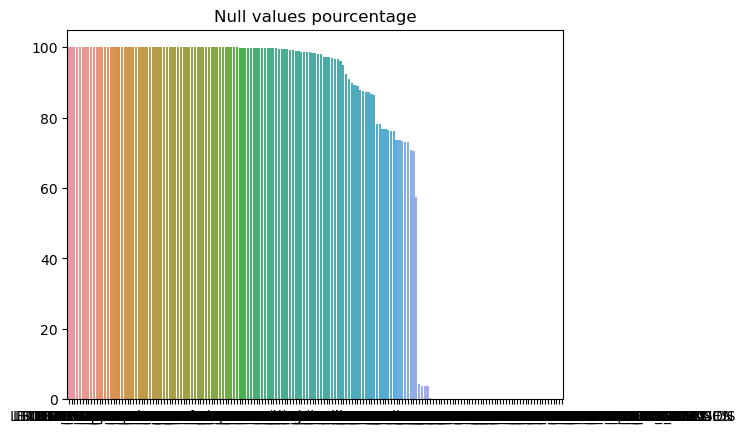

In [31]:
# Hist of NA per column
null_values = df_matrixAll_woTime.isnull().mean().sort_values(ascending=False)*100
null_values = null_values[null_values>0]
sns.barplot(x=null_values.index, y=null_values.values).set_title('Null values pourcentage')

In [32]:
# Delete columns with more than 10000 non NA values
df_matrixAll_woTime_woNA = df_matrixAll_woTime.dropna(thresh=10000, axis=1)
df_matrixAll_woTime_woNA.shape

(621832, 91)

In [33]:
df_matrixAll_woTime_woNA.columns

Index(['USUBJID', 'AGE', 'SEX', 'COUNTRY', 'DSDECOD', 'HODECOD',
       'INCLAS_AGENTS_ACTING_ON_THE_RENIN-ANGIOTENSIN_SYSTEM',
       'INCLAS_ANALGESICS', 'INCLAS_ANESTHETICS',
       'INCLAS_ANTIBACTERIALS_FOR_SYSTEMIC_USE', 'INCLAS_ANTIHELMINTICS',
       'INCLAS_ANTIINFLAMMATORY_AND_ANTIRHEUMATIC_PRODUCTS,_NON-STEROIDS',
       'INCLAS_ANTIMALARIALS', 'INCLAS_ANTIMYCOTICS_FOR_SYSTEMIC_USE',
       'INCLAS_ANTITHROMBOTIC_AGENTS', 'INCLAS_ANTIVIRALS_FOR_SYSTEMIC_USE',
       'INCLAS_ARTIFICIAL_RESPIRATION', 'INCLAS_BETA_BLOCKING_AGENTS',
       'INCLAS_BLOOD_SUBSTITUTES_AND_PERFUSION_SOLUTIONS',
       'INCLAS_BRONCHOSCOPY', 'INCLAS_CARDIAC_PACING',
       'INCLAS_CARDIAC_THERAPY', 'INCLAS_CARDIOPULMONARY_RESUSCITATION',
       'INCLAS_CHEMOTHERAPY', 'INCLAS_CORTICOSTEROIDS_FOR_SYSTEMIC_USE',
       'INCLAS_DIURETICS', 'INCLAS_DRUGS_FOR_ACID_RELATED_DISORDERS',
       'INCLAS_DRUGS_FOR_OBSTRUCTIVE_AIRWAY_DISEASES',
       'INCLAS_EXTRACORPOREAL_MEMBRANE_OXYGENATION',
       'INCLAS_H

### 5.2 Investigate if the data missing at random or not ?

<AxesSubplot:>

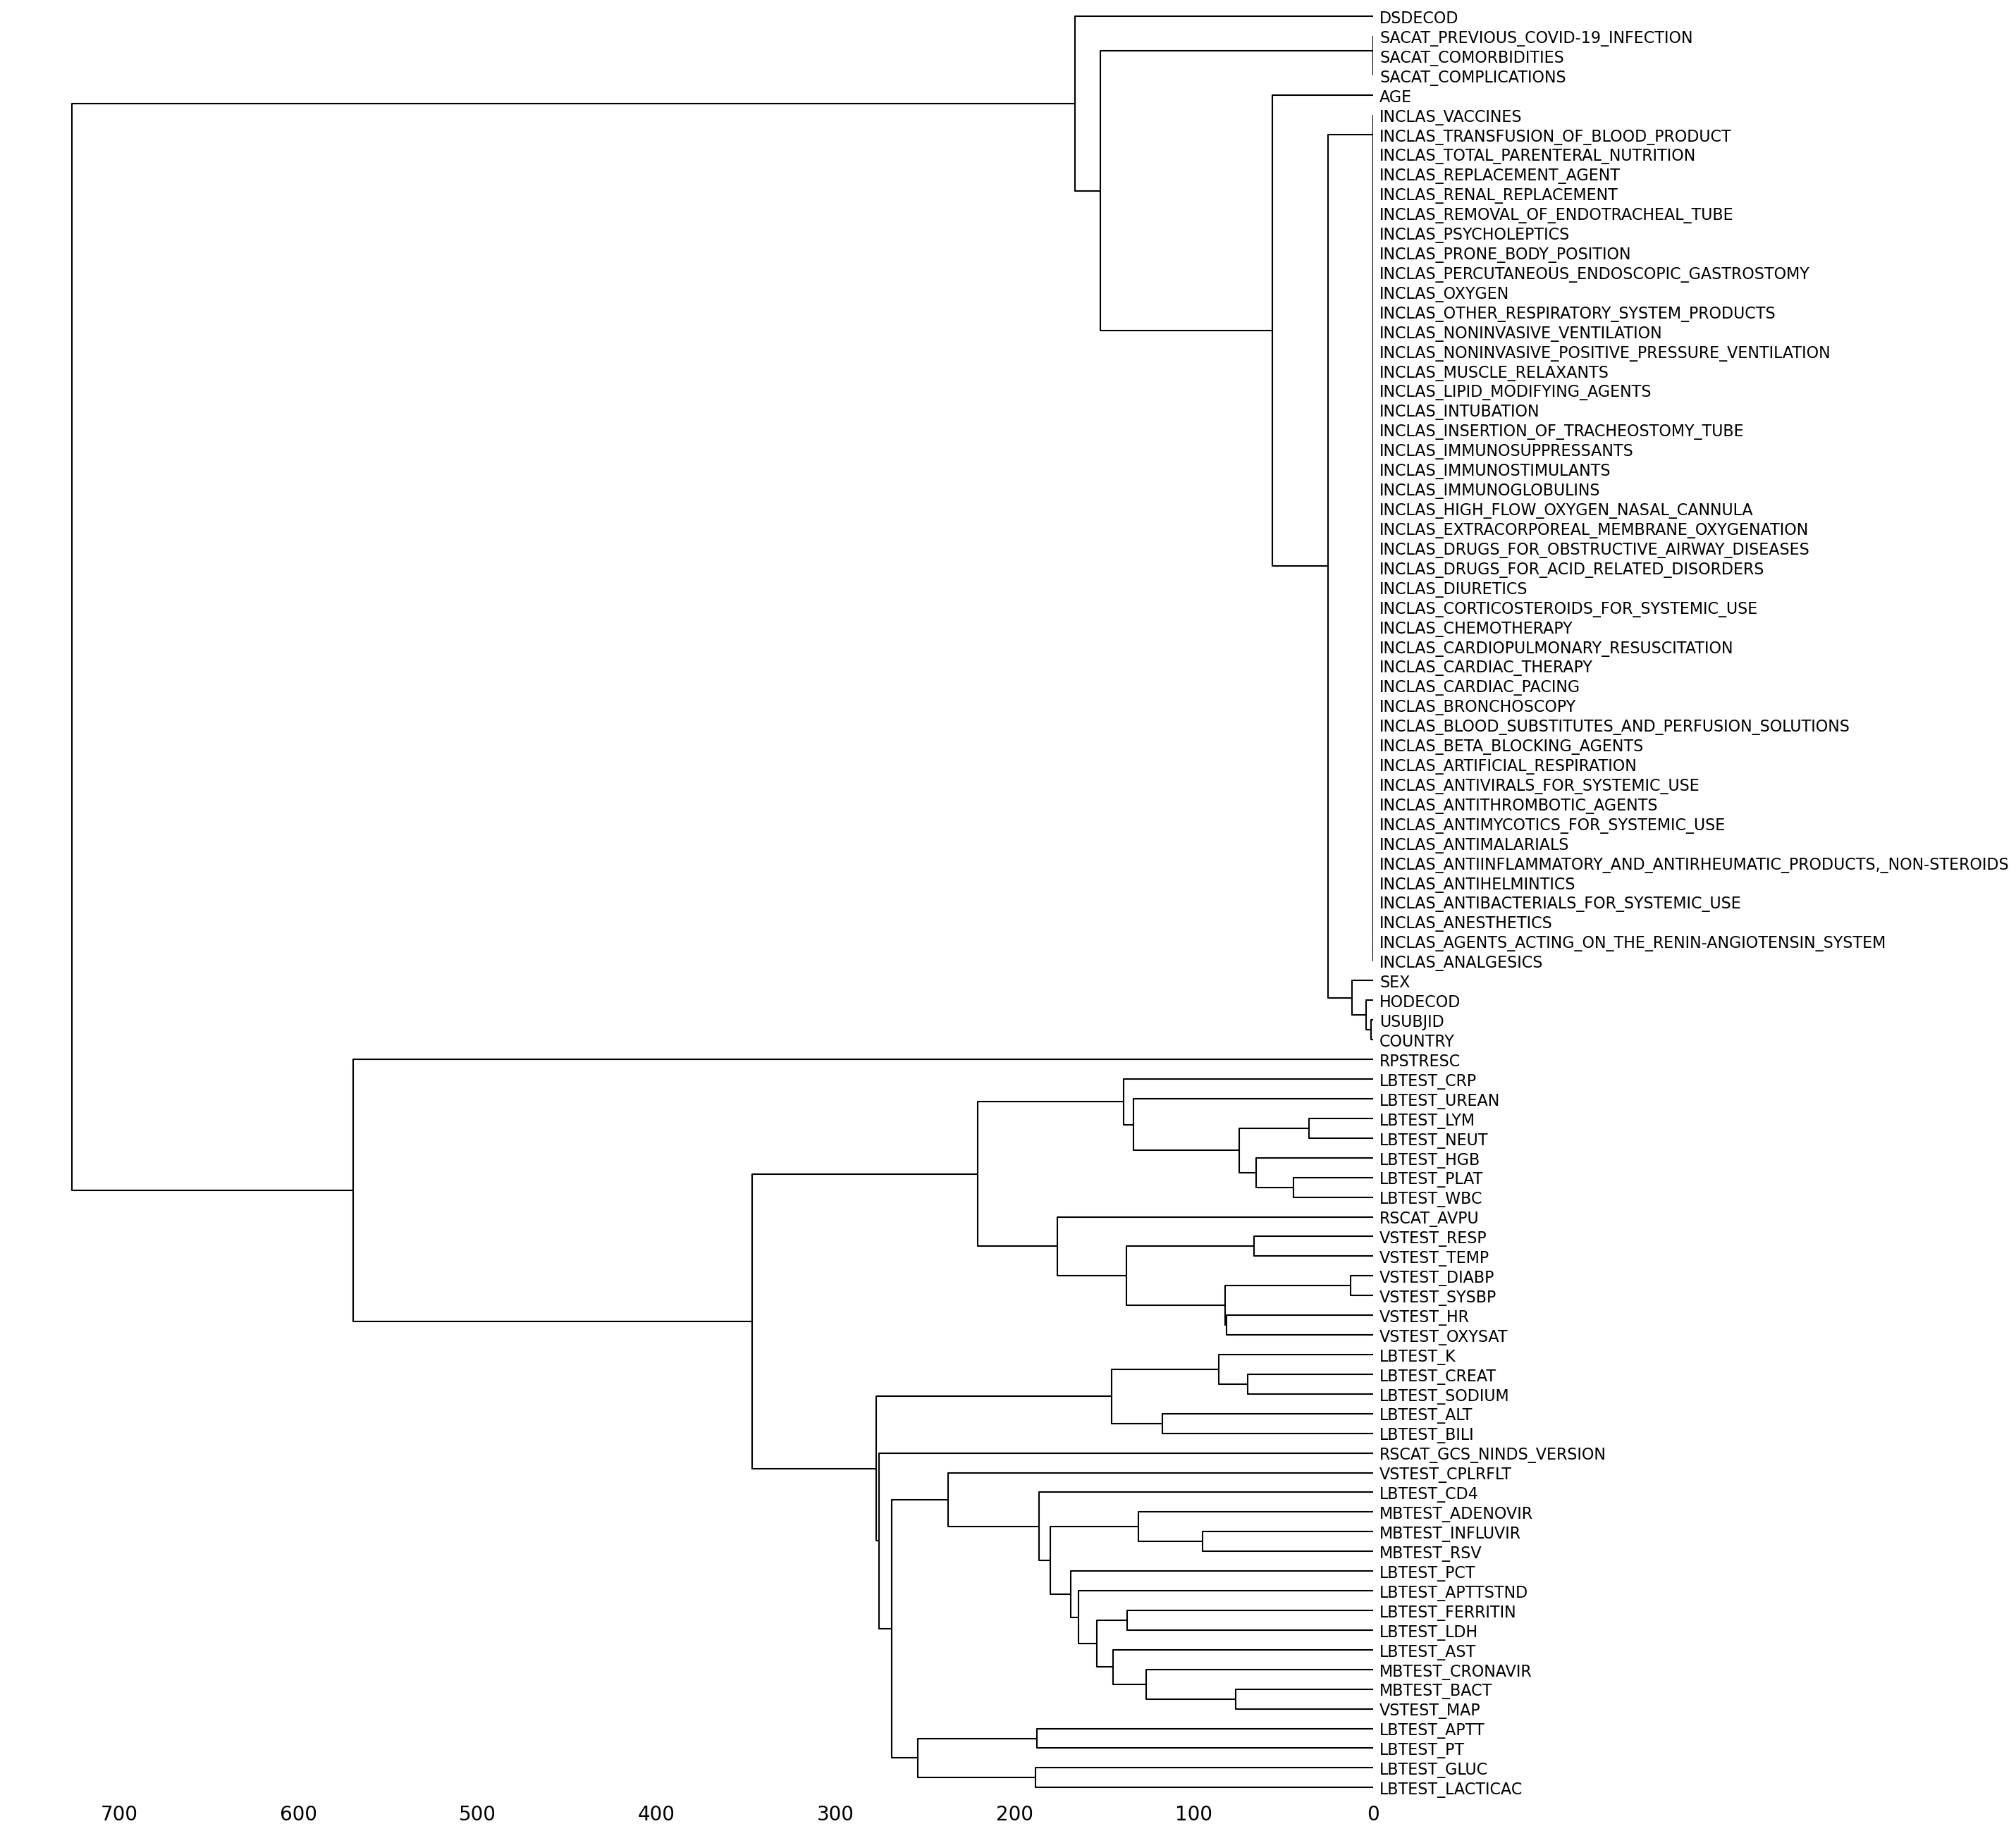

In [34]:
# Missingness Dendrogram
msno.dendrogram(df_matrixAll_woTime_woNA)

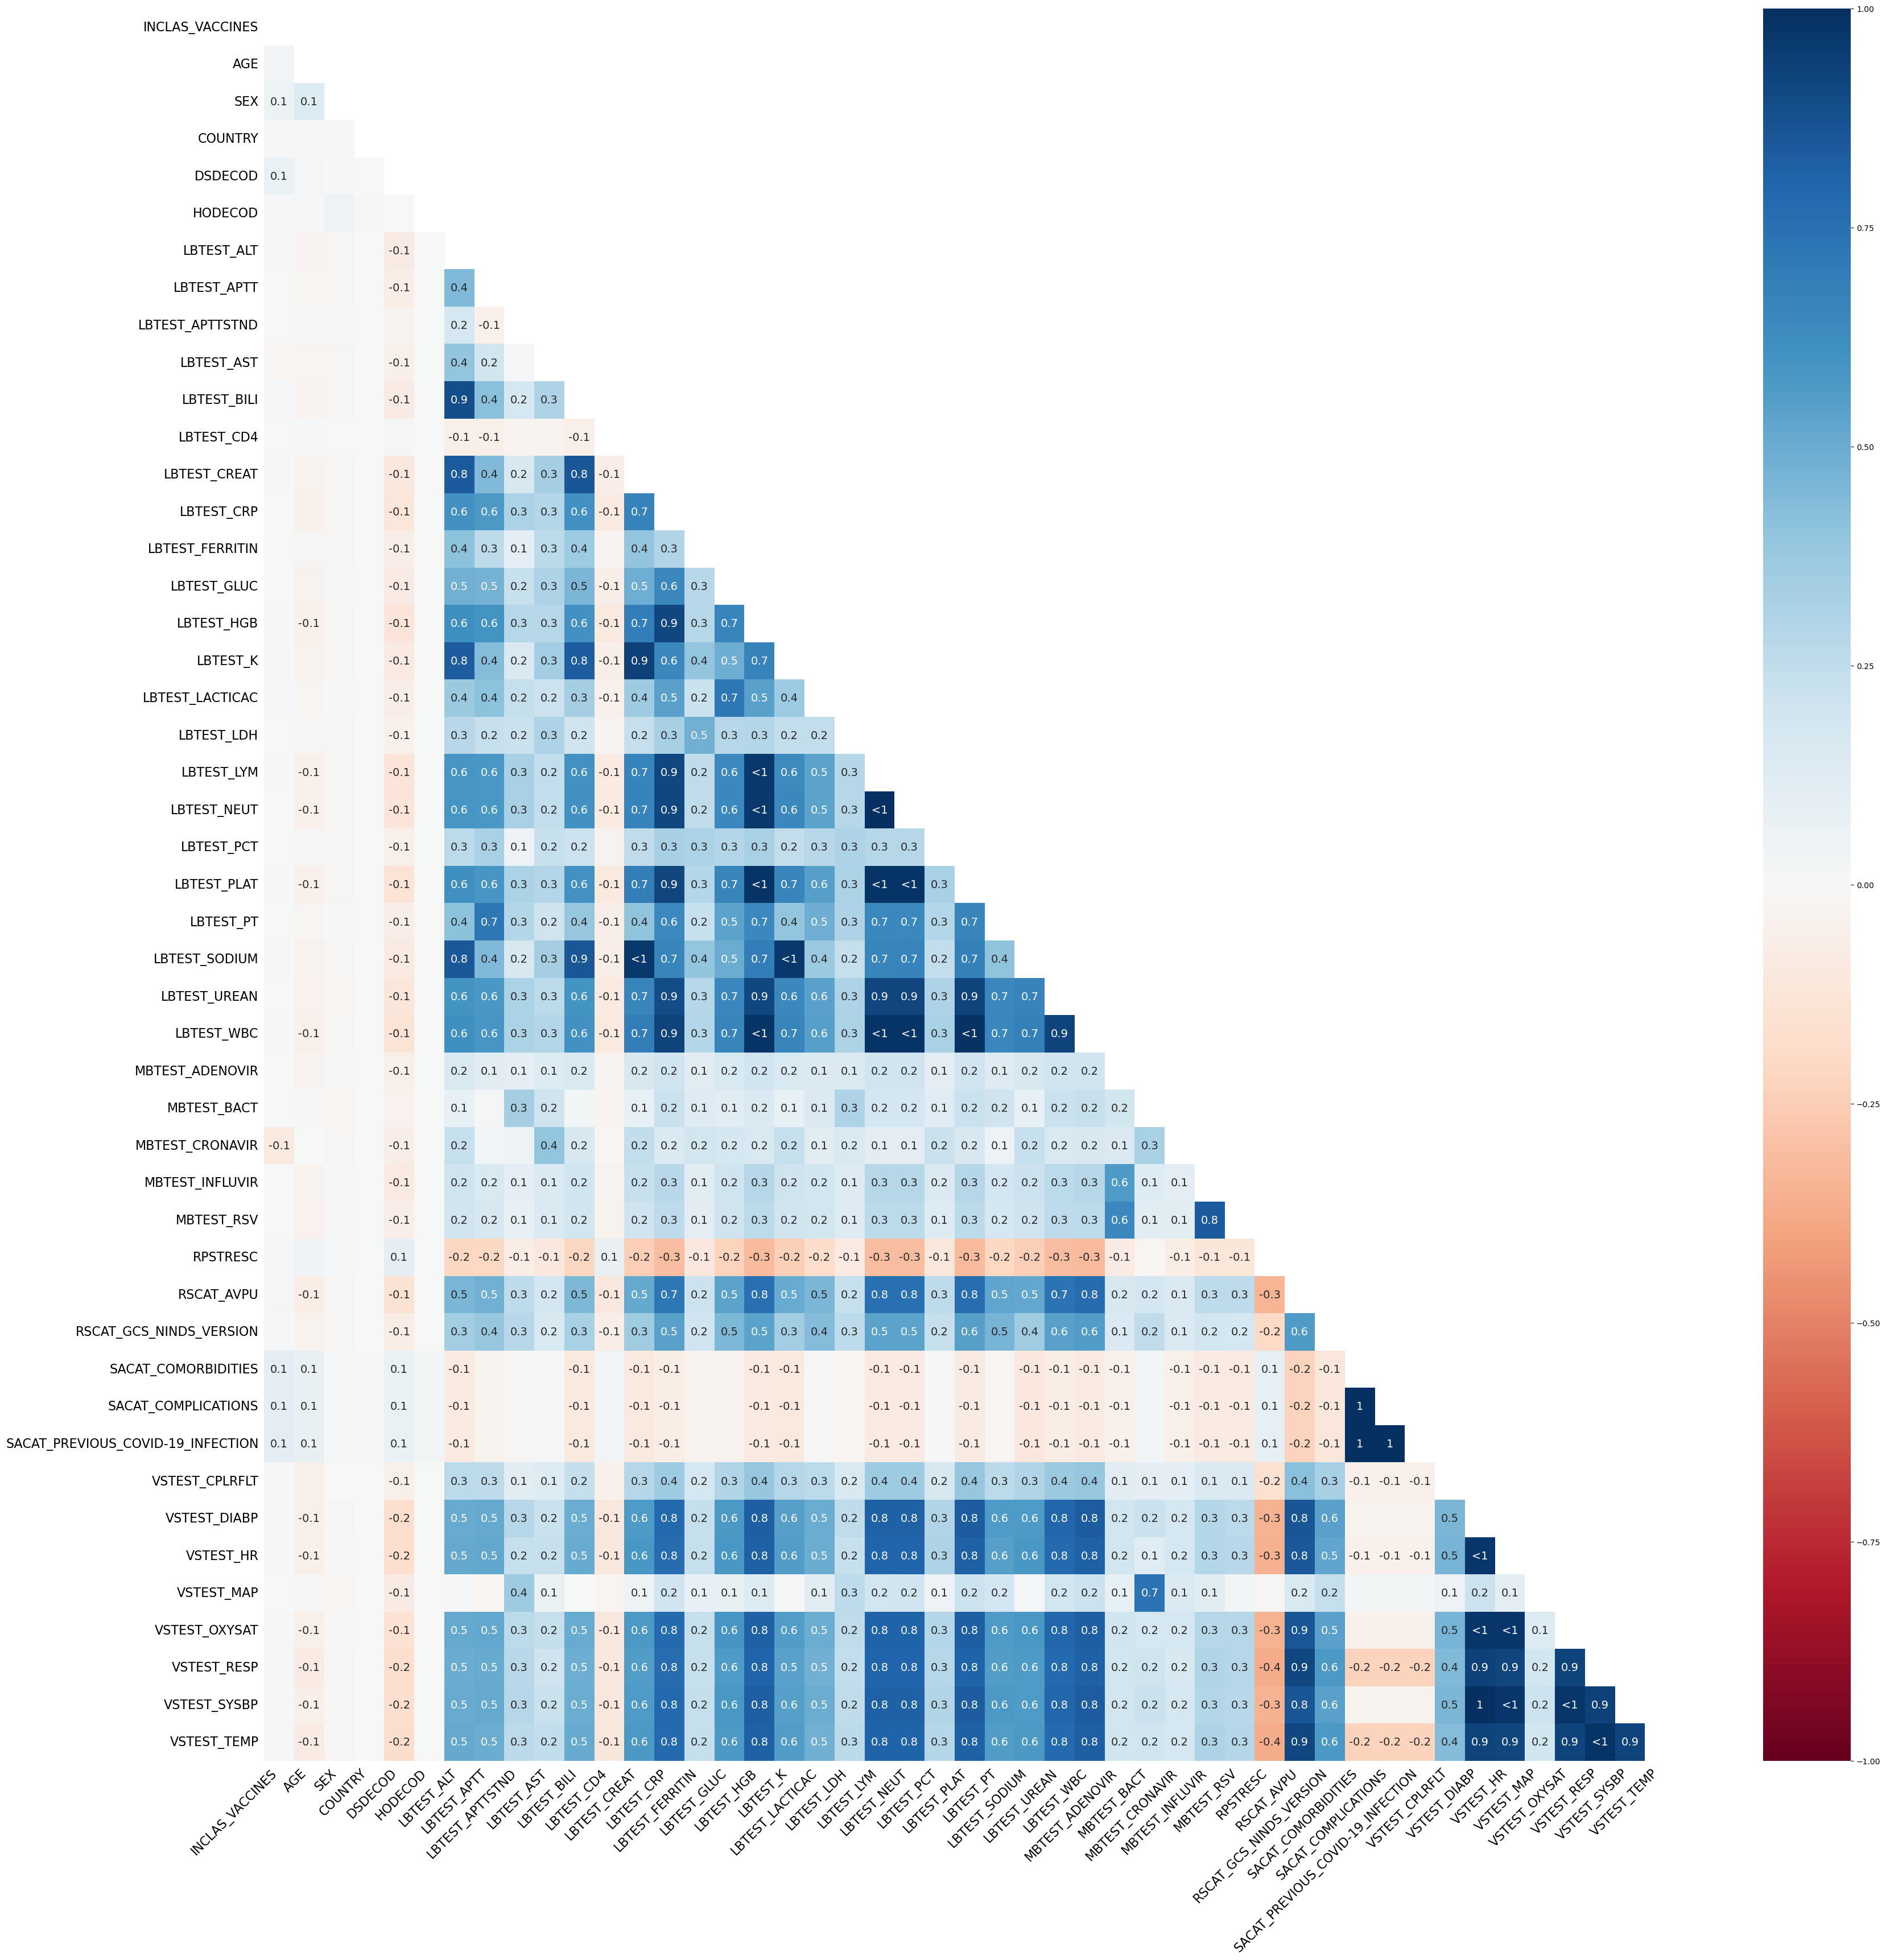

In [35]:
# Missingness Heatmap

# We will use only one INCLAS column to do the heatmap because we saw that the NA were well correlated
df_heatmap = df_matrixAll_woTime_woNA[df_matrixAll_woTime_woNA.columns.drop(list(df_matrixAll_woTime_woNA.filter(regex='INCLAS')))]
df_heatmap.insert(0,'INCLAS_VACCINES', df_matrixAll_woTime_woNA.INCLAS_VACCINES)

fig, ax = plt.subplots(1,1,figsize=(40,40))
msno.heatmap(df_heatmap, ax=ax, labels=True)
plt.savefig('./data/results/NA_heatmap.png')

C:\Users\felic\anaconda3\envs\ada\lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


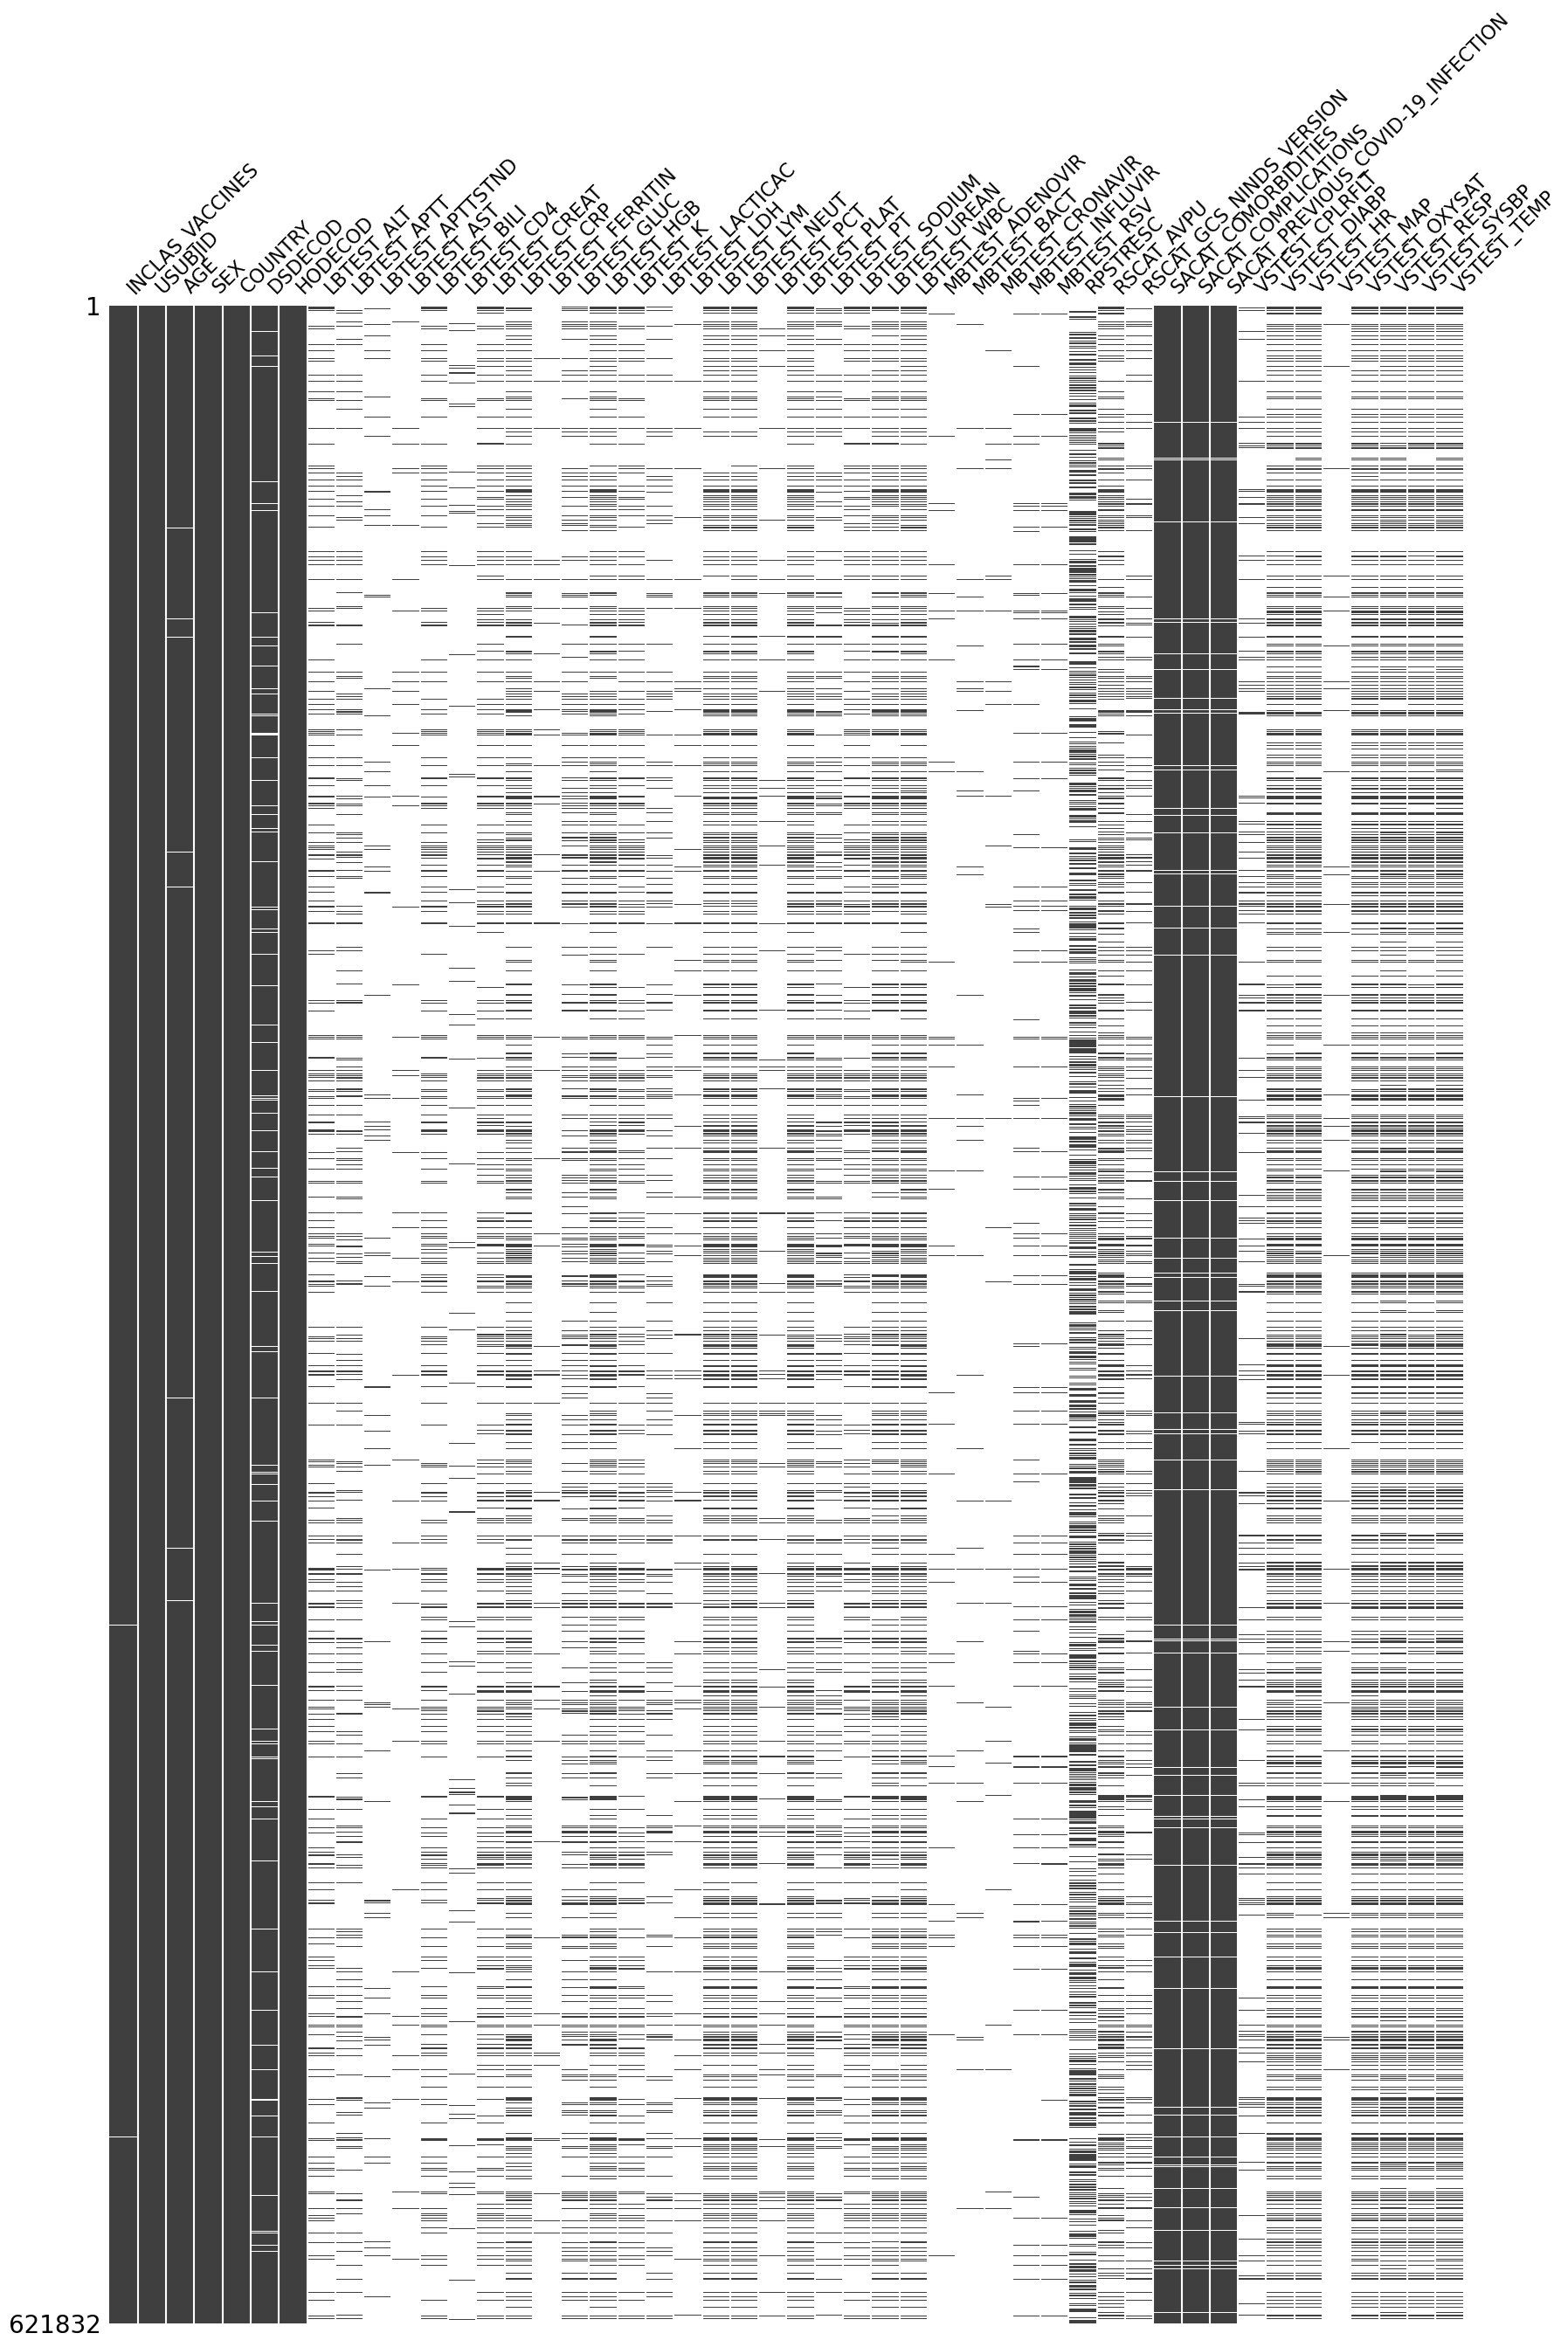

In [36]:
# Visualize NA
# We will use only one INCLAS column to do the heatmap because we saw that the NA were well correlated
fig, ax = plt.subplots(1,1,figsize=(20,30))
msno.matrix(df_heatmap, ax=ax, labels=True)
plt.savefig('./data/results/NA_matrix.png')

<AxesSubplot:>

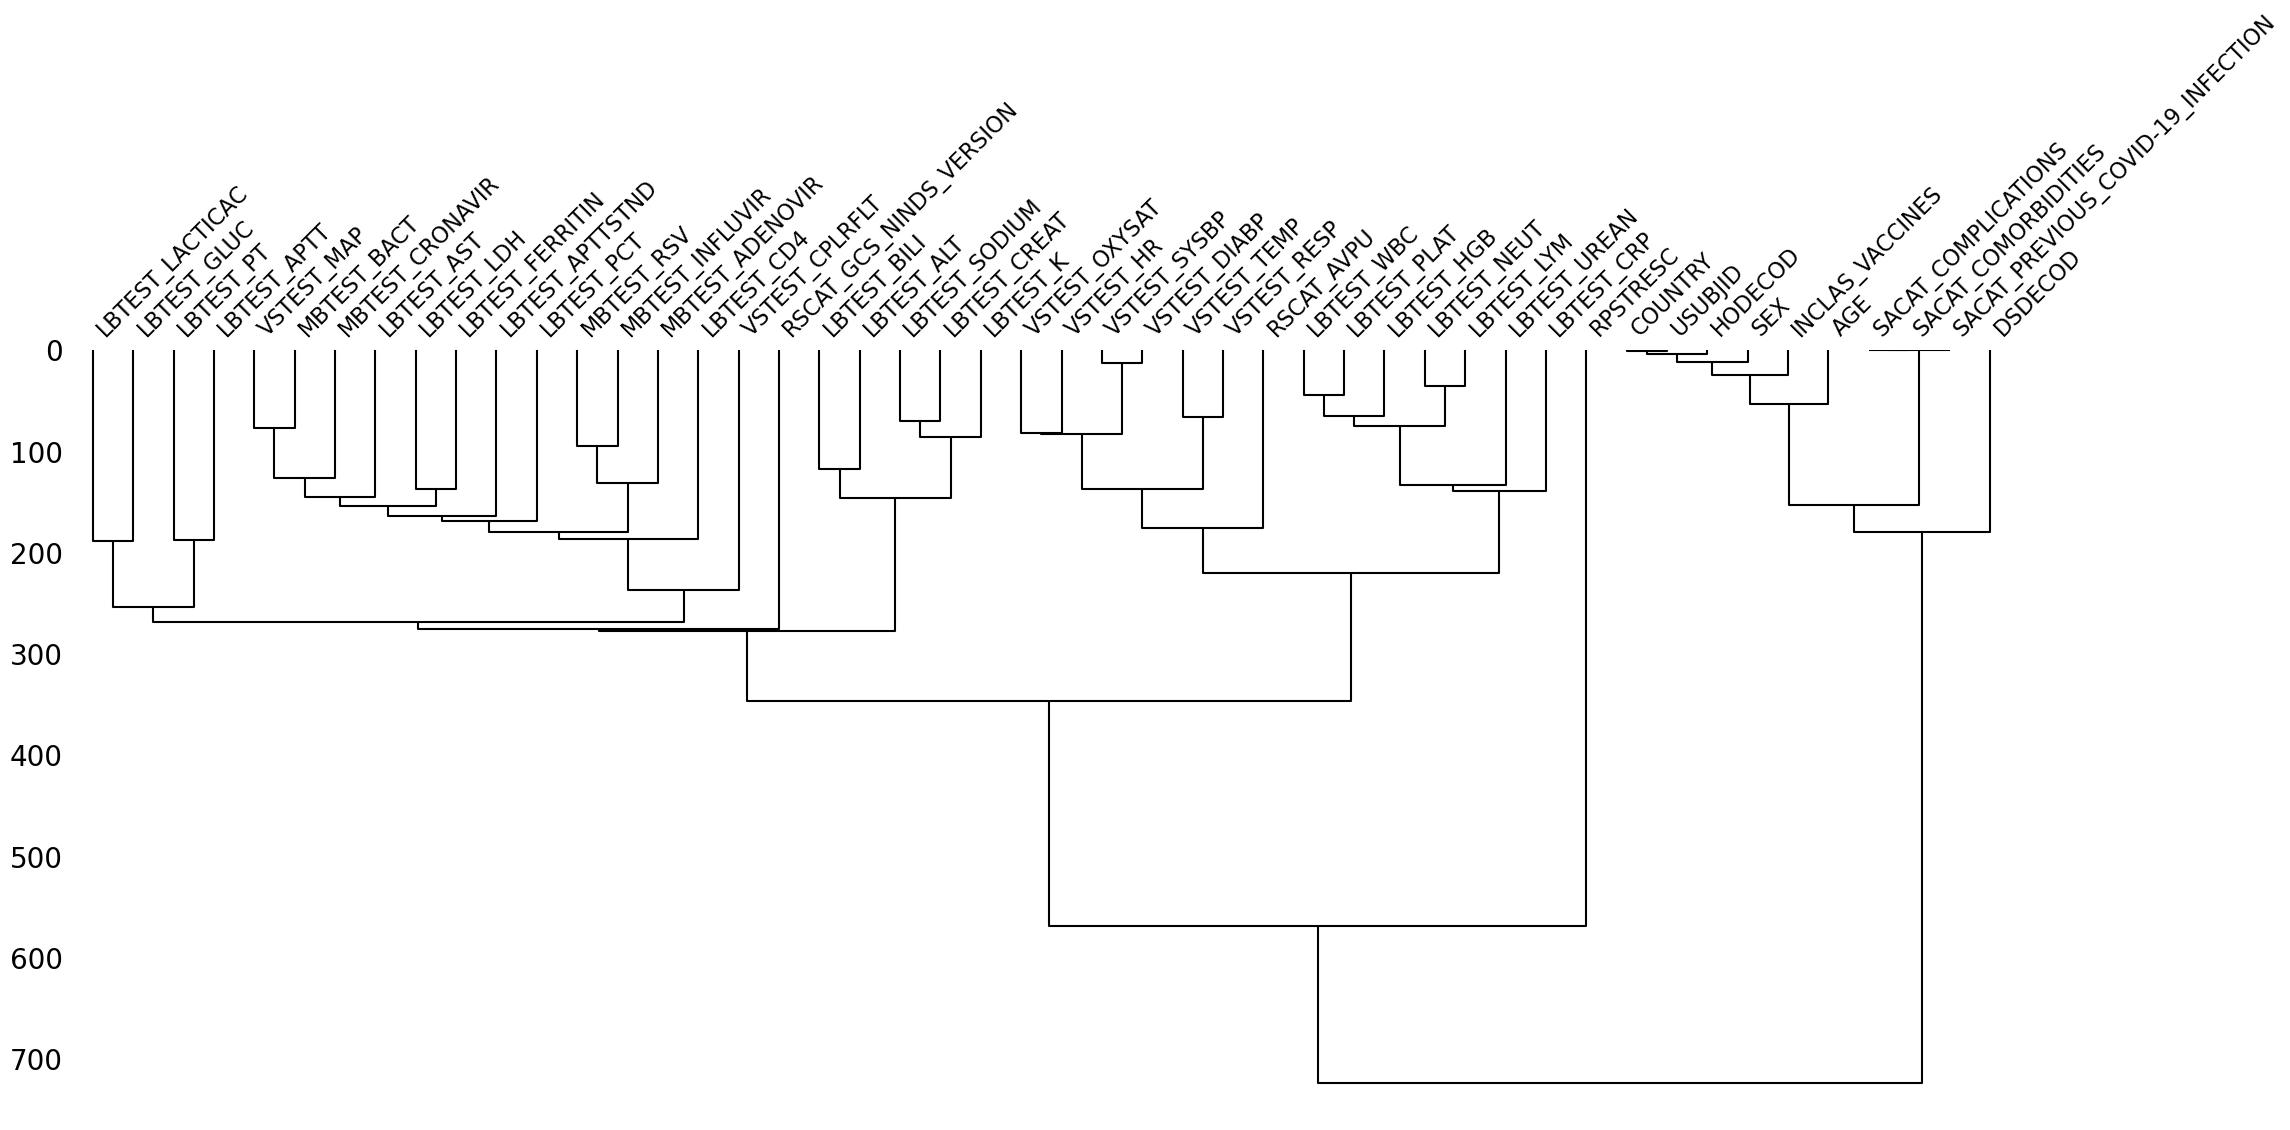

In [37]:
# Missingness Dendrogram
# We will use only one INCLAS column to do the heatmap because we saw that the NA were well correlated
msno.dendrogram(df_heatmap)

### 5.3 Conclusion

In [38]:
# Save
df_matrixAll_woTime_woNA.to_csv('./data/results/df_matrixAll_woTime_woNA.csv')

**NA are not at random.** => Solutions : 
- Either delete columns with too many NA (but be careful not to delete rows, otherwise there is a bias) -> in order to do a regression for example. 
- Or complete the columns with methods to fillNA (but introduce a bias because we do not have NA at random), 
- Or use an algo for which NA is not a problem.

## 6. EDA

In [39]:
# Open file
data_folder = './data/results/'
mylist = []
for chunk in pd.read_csv(data_folder + 'df_matrixAll_woTime_woNA.csv', sep=',', low_memory=False, chunksize=5000):
    mylist.append(chunk)
df = pd.concat(mylist, axis=0)
df.name = 'df'
del mylist

In [56]:
df.drop(columns=['Unnamed: 0', 'USUBJID'], inplace=True)

In [57]:
df.shape

(621832, 90)

In [ ]:
# EDA on df
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_file("./data/results/EDA_df.html")
# Error : Unable to allocate 49.5 TiB for an array with shape (6796662741341,) and data type float64

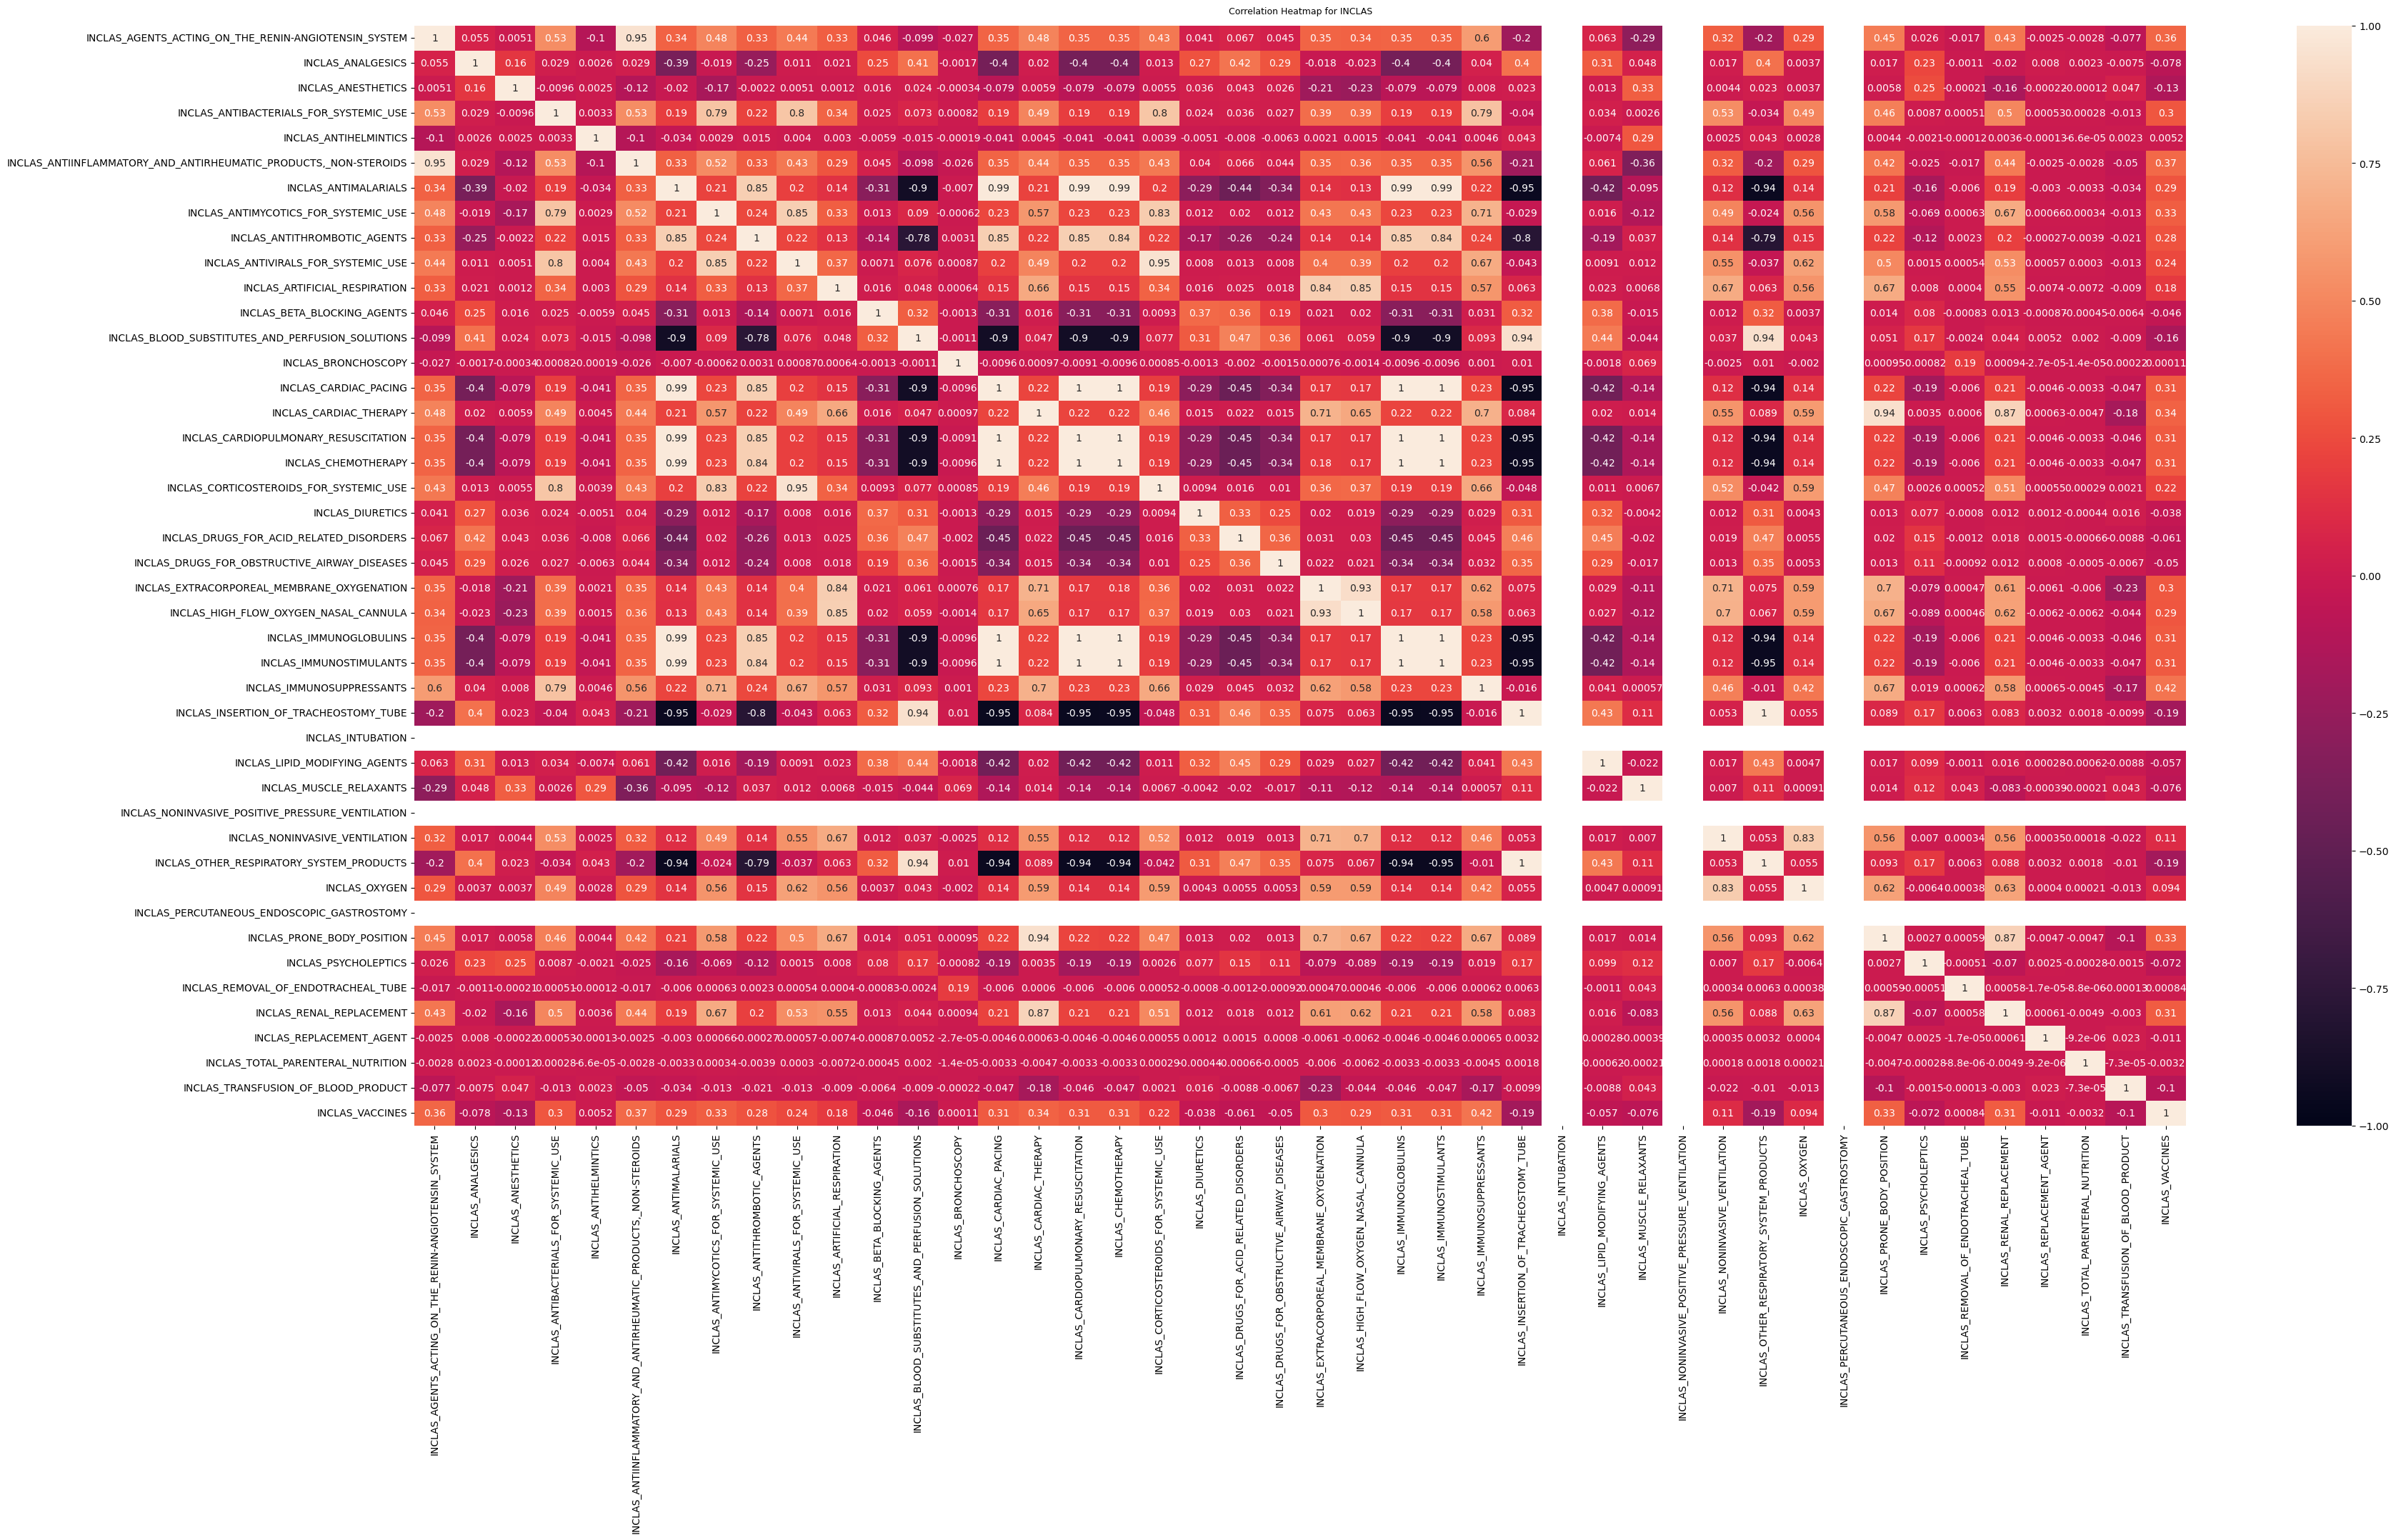

In [61]:
# Correlation heatmap for INCLAS

# We will use INCLAS column to do the heatmap
df_corrHeatmap_INCLAS = df.filter(regex='INCLAS')

plt.figure(figsize=(40, 20))
heatmap = sns.heatmap(df_corrHeatmap_INCLAS.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap for INCLAS', fontdict={'fontsize':9}, pad=12)
plt.savefig('./data/results/corrHeatmap_INCLAS.png')

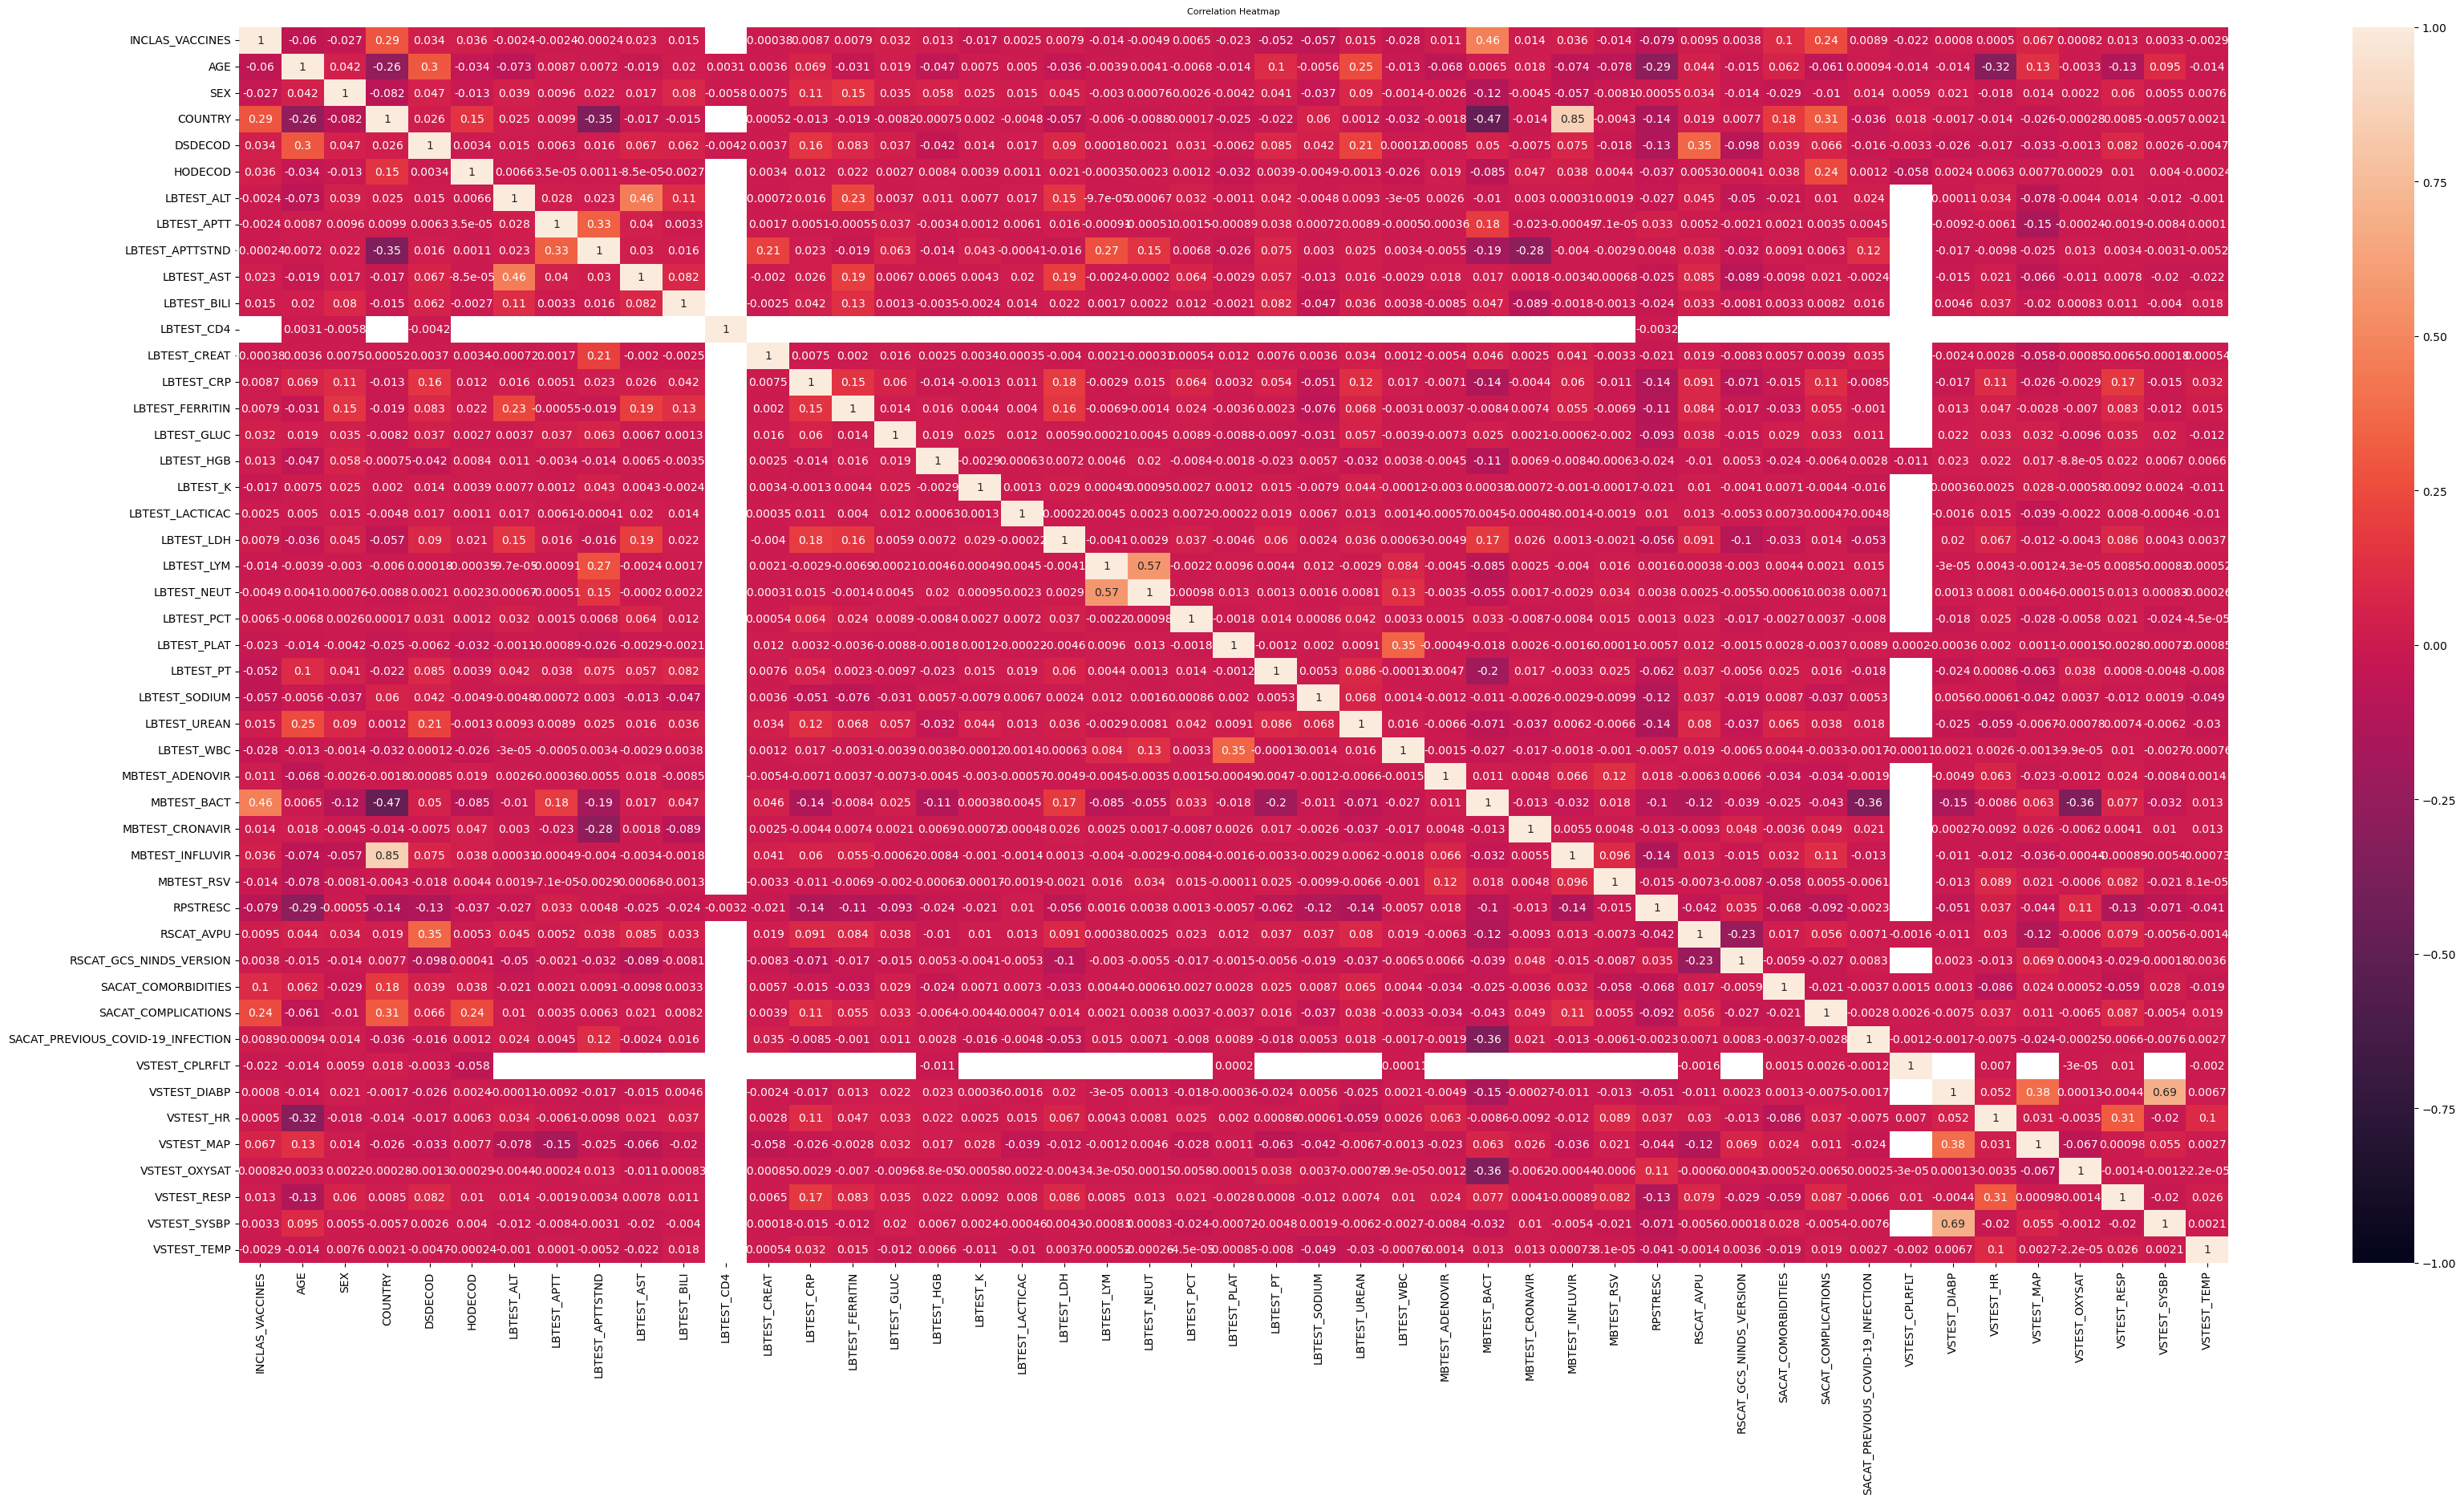

In [58]:
# Correlation heatmap with only vaccines for INCLAS

# We will use only one INCLAS column to do the heatmap
df_corrHeatmap = df[df.columns.drop(list(df.filter(regex='INCLAS')))]
df_corrHeatmap.insert(0,'INCLAS_VACCINES', df.INCLAS_VACCINES)

plt.figure(figsize=(40, 20))
heatmap = sns.heatmap(df_corrHeatmap.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap with only vaccines for INCLAS', fontdict={'fontsize':8}, pad=12)
plt.savefig('./data/results/corrHeatmap.png')

In [66]:
# Top Absolute Correlations for INCLAS

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations for INCLAS")
print(get_top_abs_correlations(df_corrHeatmap_INCLAS, 30))

Top Absolute Correlations for INCLAS
INCLAS_CARDIAC_PACING                                 INCLAS_CARDIOPULMONARY_RESUSCITATION                                0.999970
                                                      INCLAS_IMMUNOGLOBULINS                                              0.999813
INCLAS_CHEMOTHERAPY                                   INCLAS_IMMUNOSTIMULANTS                                             0.999790
INCLAS_CARDIOPULMONARY_RESUSCITATION                  INCLAS_IMMUNOGLOBULINS                                              0.999783
INCLAS_CARDIAC_PACING                                 INCLAS_IMMUNOSTIMULANTS                                             0.999464
INCLAS_CARDIOPULMONARY_RESUSCITATION                  INCLAS_IMMUNOSTIMULANTS                                             0.999434
INCLAS_CARDIAC_PACING                                 INCLAS_CHEMOTHERAPY                                                 0.999374
INCLAS_CARDIOPULMONARY_RESUSCITATION          

In [67]:
# Top Absolute Correlations with only vaccines for INCLAS
print("Top Absolute Correlations with only vaccines for INCLAS")
print(get_top_abs_correlations(df_corrHeatmap, 15))

Top Absolute Correlations with only vaccines for INCLAS
COUNTRY          MBTEST_INFLUVIR                      0.854581
VSTEST_DIABP     VSTEST_SYSBP                         0.690003
LBTEST_LYM       LBTEST_NEUT                          0.573339
COUNTRY          MBTEST_BACT                          0.473504
INCLAS_VACCINES  MBTEST_BACT                          0.464195
LBTEST_ALT       LBTEST_AST                           0.458456
VSTEST_DIABP     VSTEST_MAP                           0.383581
MBTEST_BACT      SACAT_PREVIOUS_COVID-19_INFECTION    0.359224
                 VSTEST_OXYSAT                        0.355503
COUNTRY          LBTEST_APTTSTND                      0.353522
DSDECOD          RSCAT_AVPU                           0.353409
LBTEST_PLAT      LBTEST_WBC                           0.348656
LBTEST_APTT      LBTEST_APTTSTND                      0.333117
AGE              VSTEST_HR                            0.320003
VSTEST_HR        VSTEST_RESP                          0.307523

In [ ]:
# TODO : Faire feature selection sur df

In [68]:
# Save
df.to_csv('./data/results/df.csv')